# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [12]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [13]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [14]:
# def retrieveCfbData(endpoint, team, year, week, season_type):
#     file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)

# def retrieveRemoteCfbGame(game_id, year):
#     file_path = f"data/games/game-data-{game_id}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)
    

In [15]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
ep_data = ep_data.ep.to_list()

punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')


def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [16]:
base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
#     if "ï»¿id" in drive.columns:
#         drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
#     if "ï»¿id" in gm.columns:
#         gm["id"] = gm["ï»¿id"]
    gm = gm[(gm.home_points.notnull()) & (gm.away_points.notnull())]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
#     if "ï»¿id" in plys.columns:
#         plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 7184
Total Drives: 185111
Total Plays: 1303741


In [17]:
games.head()

,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,...,away_line_scores[3],away_post_win_prob,year,Unnamed: 0,game_id,start_time_tbd,home_id,away_id,excitement_index,highlights
0,322432309.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15121.0,3696.0,Dix Stadium,...,14.0,0.644572,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322432006.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,12616.0,3768.0,Summa Field at InfoCision Stadium,...,7.0,0.796214,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322430238.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,38393.0,3973.0,Vanderbilt Stadium,...,7.0,0.518995,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322432117.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15250.0,3786.0,Kelly/Shorts Stadium,...,0.0,0.369692,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322432050.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,12725.0,3919.0,Scheumann Stadium,...,13.0,0.020080,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
base_drives.head()

,Unnamed: 0,offense,offense_conference,defense,defense_conference,game_id,drive_id,drive_number,scoring,start_period,...,time_minutes_start,time_seconds_start,time_minutes_end,time_seconds_end,time_minutes_elapsed,time_seconds_elapsed,year,start_time.hours,end_time.hours,elapsed.hours
0,1,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000901,1,True,1,...,15,0,11,26,3,34,2012,NaN,NaN,NaN
1,2,Northern Arizona,NaN,Arizona State,Pac-12,322430009,32243000902,2,False,1,...,11,26,8,36,2,50,2012,NaN,NaN,NaN
2,3,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000903,3,True,1,...,8,36,6,10,2,26,2012,NaN,NaN,NaN
3,4,Northern Arizona,NaN,Arizona State,Pac-12,322430009,32243000904,4,False,1,...,6,10,4,32,1,38,2012,NaN,NaN,NaN
4,5,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000905,5,False,1,...,4,32,2,34,1,58,2012,NaN,NaN,NaN


In [19]:
pbp_data.head()

,Unnamed: 0,id_play,offense_play,offense_conference,defense_play,defense_conference,home,away,offense_score,defense_score,...,drive_pts,season,wk,year,spread.x,formatted_spread.x,over_under.x,spread.y,formatted_spread.y,over_under.y
0,1,322430009002,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
1,2,322430009003,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
2,3,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
3,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
4,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
croot_data = pd.DataFrame()

for i in range(2007, 2022):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44347


In [21]:
production = pd.DataFrame()
for i in range(2015, 2022):
    k = retrieveCfbDataFile('production',i)
    k['year'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.team == team) & (production.year == yr)]
    if (len(team_slice) == 0):
        return production[(production.year == yr)].overall.quantile(.02)
    return team_slice.overall.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,team,offense,defense,overall,year
0,UMass,0.90,0.90,0.90,2015
1,North Carolina,0.92,0.81,0.87,2015
2,Charlotte,0.89,0.84,0.86,2015
3,Ohio,0.84,0.86,0.85,2015
4,Georgia State,0.75,0.94,0.84,2015
5,Temple,0.77,0.90,0.83,2015
6,Ball State,0.96,0.70,0.83,2015
7,Vanderbilt,0.74,0.91,0.82,2015
8,Texas Tech,0.80,0.83,0.82,2015
9,California,0.84,0.79,0.82,2015


In [22]:
# Game cleaning
games.reset_index(inplace = True) 
print(f"Bugged years without id field: {games[(games.id.isna()) & (games.game_id.notna())].year.unique()}")
print(f"Nonbugged years with id field properly set and not game_id: {games[(games.id.notna()) & (games.game_id.isna())].year.unique()}")
games["id"] = np.where(games.game_id.notna(), games.game_id, games.id)
print(f"All years should be here: {games[(games.id.notna())].year.unique()}")

print(f"Before: {games.columns}")
games.drop(['home_line_scores[0]',
       'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]',
       'away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]',
       'away_line_scores[3]', 'Unnamed: 0',
       'game_id', 'start_time_tbd', 'home_id', 'away_id', 'excitement_index',
       'highlights'], axis=1, inplace=True)
print(f"After: {games.columns}")

games.head()

Bugged years without id field: [2020]
Nonbugged years with id field properly set and not game_id: [2012 2013 2014 2015 2016 2017 2018 2019]
All years should be here: [2012 2013 2014 2015 2016 2017 2018 2019 2020]
Before: Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 'venue_id', 'venue',
       'home_team', 'home_conference', 'home_points', 'home_line_scores[0]',
       'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]',
       'home_post_win_prob', 'away_team', 'away_conference', 'away_points',
       'away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]',
       'away_line_scores[3]', 'away_post_win_prob', 'year', 'Unnamed: 0',
       'game_id', 'start_time_tbd', 'home_id', 'away_id', 'excitement_index',
       'highlights'],
      dtype='object')
After: Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 

,index,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,home_team,home_conference,home_points,home_post_win_prob,away_team,away_conference,away_points,away_post_win_prob,year
0,0,322432309.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15121.0,3696.0,Dix Stadium,Kent State,Mid-American,41.0,0.355428,Towson,NaN,21.0,0.644572,2012
1,1,322432006.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,12616.0,3768.0,Summa Field at InfoCision Stadium,Akron,Mid-American,14.0,0.203786,UCF,Conference USA,56.0,0.796214,2012
2,2,322430238.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,38393.0,3973.0,Vanderbilt Stadium,Vanderbilt,SEC,13.0,0.481005,South Carolina,SEC,17.0,0.518995,2012
3,3,322432117.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15250.0,3786.0,Kelly/Shorts Stadium,Central Michigan,Mid-American,38.0,0.630308,Southeast Missouri State,NaN,27.0,0.369692,2012
4,4,322432050.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,12725.0,3919.0,Scheumann Stadium,Ball State,Mid-American,37.0,0.979920,Eastern Michigan,Mid-American,26.0,0.020080,2012


In [23]:
# Drive cleaning
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives["drive_pts"] = np.select(
    [
        (base_drives.end_offense_score - base_drives.start_offense_score > 0),
        (base_drives.end_defense_score - base_drives.start_defense_score > 0)
    ],
    [
        (base_drives.end_offense_score - base_drives.start_offense_score),
        (base_drives.end_defense_score - base_drives.start_defense_score)
    ]
, default=0)
print(f"Before: {base_drives.columns}")
base_drives.drop(['Unnamed: 0','offense_conference','defense_conference',"drive_number","start_yards_to_goal","end_yards_to_goal",
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'time_minutes_start',
       'time_seconds_start', 'time_minutes_end', 'time_seconds_end',
       'time_minutes_elapsed', 'time_seconds_elapsed','start_time.hours', 'end_time.hours',
       'elapsed.hours'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
# drives.rename(columns={'id':'drive_id'}, inplace=True)
drives.drop(['id'], axis = 1, inplace=True)
print(f"After: {drives.columns}")
drives.head()

Before: Index(['index', 'Unnamed: 0', 'offense', 'offense_conference', 'defense',
       'defense_conference', 'game_id', 'drive_id', 'drive_number', 'scoring',
       'start_period', 'start_yardline', 'start_yards_to_goal', 'end_period',
       'end_yardline', 'end_yards_to_goal', 'plays', 'yards', 'drive_result',
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'time_minutes_start',
       'time_seconds_start', 'time_minutes_end', 'time_seconds_end',
       'time_minutes_elapsed', 'time_seconds_elapsed', 'year',
       'start_time.hours', 'end_time.hours', 'elapsed.hours', 'drive_pts'],
      dtype='object')
After: Index(['index', 'offense', 'defense', 'game_id', 'drive_id', 'scoring',
       'start_period', 'start_yardline', 'end_period', 'end_yardline', 'plays',
       'yards', 'drive_result', 'year', 'drive_pts', 'away_team', 'home_team'],
      dtype='object')


,index,offense,defense,game_id,drive_id,scoring,start_period,start_yardline,end_period,end_yardline,plays,yards,drive_result,year,drive_pts,away_team,home_team
0,0.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,True,1.0,27.0,1.0,100.0,9.0,73.0,RUSHING TD,2012.0,7.0,Northern Arizona,Arizona State
1,1.0,Northern Arizona,Arizona State,322430009.0,3.224300e+10,False,1.0,85.0,1.0,80.0,4.0,5.0,PUNT,2012.0,0.0,Northern Arizona,Arizona State
2,2.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,True,1.0,19.0,1.0,100.0,7.0,81.0,RUSHING TD,2012.0,7.0,Northern Arizona,Arizona State
3,3.0,Northern Arizona,Arizona State,322430009.0,3.224300e+10,False,1.0,61.0,1.0,56.0,3.0,5.0,PUNT,2012.0,0.0,Northern Arizona,Arizona State
4,4.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,False,1.0,15.0,1.0,74.0,7.0,56.0,FUMBLE,2012.0,0.0,Northern Arizona,Arizona State


In [24]:
drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

# drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 184071


In [25]:
pbp_data.reset_index(inplace = True) 
print(f"Before: {pbp_data.columns}")

pbp_data["play_id"] = pbp_data.id_play
pbp_data["offense"] = pbp_data.offense_play
pbp_data["defense"] = pbp_data.defense_play
pbp_data.drop(['index','offense_play','defense_play', 'Unnamed: 0','id_play','clock.minutes', 'clock.seconds', 'offense_timeouts',
       'defense_timeouts','ppa', 'spread',
       'formatted_spread', 'over_under', 'wk',
       'spread.x', 'formatted_spread.x', 'over_under.x', 'spread.y',
       'formatted_spread.y', 'over_under.y','orig_drive_number', 'drive_scoring',
       'drive_start_period', 'drive_start_yards_to_goal', 'drive_end_period',
       'drive_end_yards_to_goal', 'drive_yards', 'drive_result',
       'drive_is_home_offense', 'drive_start_offense_score',
       'drive_start_defense_score', 'drive_end_offense_score',
       'drive_end_defense_score', 'drive_time_minutes_start',
       'drive_time_seconds_start', 'drive_time_minutes_end',
       'drive_time_seconds_end', 'drive_time_minutes_elapsed',
       'drive_time_seconds_elapsed'], axis = 1, inplace=True)

print(f"After: {pbp_data.columns}")
pbp_data.head()

Before: Index(['index', 'Unnamed: 0', 'id_play', 'offense_play', 'offense_conference',
       'defense_play', 'defense_conference', 'home', 'away', 'offense_score',
       'defense_score', 'game_id', 'drive_id', 'drive_number', 'play_number',
       'period', 'clock.minutes', 'clock.seconds', 'offense_timeouts',
       'defense_timeouts', 'yard_line', 'yards_to_goal', 'down', 'distance',
       'scoring', 'yards_gained', 'play_type', 'play_text', 'ppa', 'spread',
       'formatted_spread', 'over_under', 'orig_drive_number', 'drive_scoring',
       'drive_start_period', 'drive_start_yards_to_goal', 'drive_end_period',
       'drive_end_yards_to_goal', 'drive_yards', 'drive_result',
       'drive_is_home_offense', 'drive_start_offense_score',
       'drive_start_defense_score', 'drive_end_offense_score',
       'drive_end_defense_score', 'drive_time_minutes_start',
       'drive_time_seconds_start', 'drive_time_minutes_end',
       'drive_time_seconds_end', 'drive_time_minutes_elapsed',


,offense_conference,defense_conference,home,away,offense_score,defense_score,game_id,drive_id,drive_number,play_number,...,scoring,yards_gained,play_type,play_text,drive_pts,season,year,play_id,offense,defense
0,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,1,...,False,16,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,7,2012,2012,322430009002,Arizona State,Northern Arizona
1,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,2,...,False,3,Rush,Cameron Marshall rush for 3 yards to the ArzSt...,7,2012,2012,322430009003,Arizona State,Northern Arizona
2,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,3,...,False,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,7,2012,2012,322430009004,Arizona State,Northern Arizona
3,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,4,...,False,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,7,2012,2012,322430009005,Arizona State,Northern Arizona
4,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,5,...,False,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,7,2012,2012,322430009006,Arizona State,Northern Arizona


In [26]:
pbp_data.play_id.nunique()

1303741

In [27]:
drives[(drives.index < 170795)].isna().any()

index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
drive_pts         False
away_team         False
home_team         False
dtype: bool

In [28]:
games.columns

Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 'venue_id', 'venue',
       'home_team', 'home_conference', 'home_points', 'home_post_win_prob',
       'away_team', 'away_conference', 'away_points', 'away_post_win_prob',
       'year'],
      dtype='object')

In [29]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [30]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Fumble Return Touchdown',
 'Pass Interception Return',
 'Rushing Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush',
 'End of Regulation']

In [31]:
# %%timeit

def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data[max(min(100, (yard_line + yards_gained)), 0)] - ep_data[max(min(yard_line, 100), 0)])

def assign_eqppp(x):
    return ep_data[max(min(100, (x.yard_line + x.yards_gained)), 0)] - ep_data[max(min(x.yard_line, 100), 0)]

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.940584903533729


In [32]:
pbp_data.head()

,offense_conference,defense_conference,home,away,offense_score,defense_score,game_id,drive_id,drive_number,play_number,...,yards_gained,play_type,play_text,drive_pts,season,year,play_id,offense,defense,EqPPP
0,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,1,...,16,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,7,2012,2012,322430009002,Arizona State,Northern Arizona,0.557474
1,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,2,...,3,Rush,Cameron Marshall rush for 3 yards to the ArzSt...,7,2012,2012,322430009003,Arizona State,Northern Arizona,0.111992
2,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,3,...,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,7,2012,2012,322430009004,Arizona State,Northern Arizona,0.038183
3,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,4,...,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,7,2012,2012,322430009005,Arizona State,Northern Arizona,0.367602
4,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,5,...,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,7,2012,2012,322430009006,Arizona State,Northern Arizona,0.802626


In [33]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_ppd_in_scoring_opps(opps, team):
    return 0 if (len(opps) == 0) else opps.drive_pts.mean()
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.select([
        (pbp_data.play_type.isin(bad_types)),
        (pbp_data.play_type.isin(st_types)),
        (pbp_data.yards_gained >= 15)
    ],
    [
        False,
        False,
        True
    ], default = False)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.select([
        (pbp_data.play_type.isin(bad_types)),
        (pbp_data.play_type.isin(st_types)), 
        ((pbp_data.down == 1) & (pbp_data.yards_gained >= (0.5 * pbp_data.distance))),
        ((pbp_data.down == 2) & (pbp_data.yards_gained >= (0.7 * pbp_data.distance))),
        ((pbp_data.down >= 4) & (pbp_data.yards_gained >= (1.0 * pbp_data.distance)))
    ],
    [
        False,
        False,
        True,
        True,
        True
    ], default = False)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [34]:
pbp_data.columns

Index(['offense_conference', 'defense_conference', 'home', 'away',
       'offense_score', 'defense_score', 'game_id', 'drive_id', 'drive_number',
       'play_number', 'period', 'yard_line', 'yards_to_goal', 'down',
       'distance', 'scoring', 'yards_gained', 'play_type', 'play_text',
       'drive_pts', 'season', 'year', 'play_id', 'offense', 'defense', 'EqPPP',
       'play_explosive', 'play_successful'],
      dtype='object')

In [35]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data[max(min(100, int(kick_yardline + distance)), 0)] - ep_data[max(min(100, kick_yardline), 0)] - ep_data[max(min(100, int(return_yards)), 0)]

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

import math
    
def calculate_box_score(game_id, year):
    if (math.isnan(game_id)):
        print(f"Provided game_id was invalid, bailing out")
        return None
    if (math.isnan(year)):
        print(f"Provided year was invalid, bailing out")
        return None
    
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            print(f"Attempted retrieval of data from API, but bailing out.")
            return None
#             game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
#             if (len(game_drives) == 0):
#                 print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
#                 return None
#             else:
#                 game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
#                 game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
#                 game_drives.drop(['id_y'], axis = 1, inplace=True)
#                 game_drives.dropna(inplace=True)

#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['start_yardline']
#                 ] = 100 - game_drives.start_yardline
#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['end_yardline']
#                 ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find local data for game_id {game_id} given {len(game_drives.drive_id)} to look for")
#         print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
#         game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
#         if (len(game_pbp) == 0):
#             print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.317460,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.095252,0.191733
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.289474,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.903519,-0.191733


In [36]:
# drv_list = drives[drives.game_id == 401013183].drive_id.to_list()
# print(drv_list)
# pbp_data[pbp_data.drive_id.isin(drv_list)].head()

In [37]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.139933,5.023642,5.379044,4.862959,4.960309,5.095252,0.191733
1,Virginia Tech,4.860067,4.976358,4.620956,5.136756,5.027691,4.903519,-0.191733


In [38]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
#         print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
#                 print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5528 box score groups by GameID.
[1/5528] Updating 5FR Margin for game_id 322430238.0...
[1/5528] Updated 5FR Margin for game_id 322430238.0.
[2/5528] Updating 5FR Margin for game_id 322430242.0...
[2/5528] Updated 5FR Margin for game_id 322430242.0.
[3/5528] Updating 5FR Margin for game_id 322430252.0...
[3/5528] Updated 5FR Margin for game_id 322430252.0.
[4/5528] Updating 5FR Margin for game_id 322432006.0...
[4/5528] Updated 5FR Margin for game_id 322432006.0.
[5/5528] Updating 5FR Margin for game_id 322432050.0...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[5/5528] Updated 5FR Margin for game_id 322432050.0.
[6/5528] Updating 5FR Margin for game_id 322432439.0...
[6/5528] Updated 5FR Margin for game_id 322432439.0.
[7/5528] Updating 5FR Margin for game_id 322440127.0...
[7/5528] Updated 5FR Margin for game_id 322440127.0.
[8/5528] Updating 5FR Margin for game_id 322442633.0...
[8/5528] Updated 5FR Margin for game_id 322442633.0.
[9/5528] Updating 5FR Margin for game_id 322450002.0...
[9/5528] Updated 5FR Margin for game_id 322450002.0.
[10/5528] Updating 5FR Margin for game_id 322450005.0...
[10/5528] Updated 5FR Margin for game_id 322450005.0.
[11/5528] Updating 5FR Margin for game_id 322450012.0...
[11/5528] Updated 5FR Margin for game_id 322450012.0.
[12/5528] Updating 5FR Margin for game_id 322450025.0...
[12/5528] Updated 5FR Margin for game_id 322450025.0.
[13/5528] Updating 5FR Margin for game_id 322450030.0...
[13/5528] Updated 5FR Margin for game_id 322450030.0.
[14/5528] Updating 5FR Margin for game_id 322450038.0...
[14/5528] 

[84/5528] Updated 5FR Margin for game_id 322590059.0.
[85/5528] Updating 5FR Margin for game_id 322590061.0...
[85/5528] Updated 5FR Margin for game_id 322590061.0.
[86/5528] Updating 5FR Margin for game_id 322590068.0...
[86/5528] Updated 5FR Margin for game_id 322590068.0.
[87/5528] Updating 5FR Margin for game_id 322590077.0...
[87/5528] Updated 5FR Margin for game_id 322590077.0.
[88/5528] Updating 5FR Margin for game_id 322590084.0...
[88/5528] Updated 5FR Margin for game_id 322590084.0.
[89/5528] Updating 5FR Margin for game_id 322590096.0...
[89/5528] Updated 5FR Margin for game_id 322590096.0.
[90/5528] Updating 5FR Margin for game_id 322590097.0...
[90/5528] Updated 5FR Margin for game_id 322590097.0.
[91/5528] Updating 5FR Margin for game_id 322590120.0...
[91/5528] Updated 5FR Margin for game_id 322590120.0.
[92/5528] Updating 5FR Margin for game_id 322590127.0...
[92/5528] Updated 5FR Margin for game_id 322590127.0.
[93/5528] Updating 5FR Margin for game_id 322590130.0...
[

[162/5528] Updated 5FR Margin for game_id 322730038.0.
[163/5528] Updating 5FR Margin for game_id 322730058.0...
[163/5528] Updated 5FR Margin for game_id 322730058.0.
[164/5528] Updating 5FR Margin for game_id 322730059.0...
[164/5528] Updated 5FR Margin for game_id 322730059.0.
[165/5528] Updating 5FR Margin for game_id 322730061.0...
[165/5528] Updated 5FR Margin for game_id 322730061.0.
[166/5528] Updating 5FR Margin for game_id 322730066.0...
[166/5528] Updated 5FR Margin for game_id 322730066.0.
[167/5528] Updating 5FR Margin for game_id 322730077.0...
[167/5528] Updated 5FR Margin for game_id 322730077.0.
[168/5528] Updating 5FR Margin for game_id 322730096.0...
[168/5528] Updated 5FR Margin for game_id 322730096.0.
[169/5528] Updating 5FR Margin for game_id 322730103.0...
[169/5528] Updated 5FR Margin for game_id 322730103.0.
[170/5528] Updating 5FR Margin for game_id 322730127.0...
[170/5528] Updated 5FR Margin for game_id 322730127.0.
[171/5528] Updating 5FR Margin for game_i

[239/5528] Updated 5FR Margin for game_id 322802132.0.
[240/5528] Updating 5FR Margin for game_id 322802483.0...
[240/5528] Updated 5FR Margin for game_id 322802483.0.
[241/5528] Updating 5FR Margin for game_id 322802579.0...
[241/5528] Updated 5FR Margin for game_id 322802579.0.
[242/5528] Updating 5FR Margin for game_id 322802628.0...
[242/5528] Updated 5FR Margin for game_id 322802628.0.
[243/5528] Updating 5FR Margin for game_id 322802641.0...
[243/5528] Updated 5FR Margin for game_id 322802641.0.
[244/5528] Updating 5FR Margin for game_id 322802649.0...
[244/5528] Updated 5FR Margin for game_id 322802649.0.
[245/5528] Updating 5FR Margin for game_id 322802711.0...
[245/5528] Updated 5FR Margin for game_id 322802711.0.
[246/5528] Updating 5FR Margin for game_id 322850038.0...
[246/5528] Updated 5FR Margin for game_id 322850038.0.
[247/5528] Updating 5FR Margin for game_id 322850202.0...
[247/5528] Updated 5FR Margin for game_id 322850202.0.
[248/5528] Updating 5FR Margin for game_i

[314/5528] Updated 5FR Margin for game_id 322940197.0.
[315/5528] Updating 5FR Margin for game_id 322940202.0...
[315/5528] Updated 5FR Margin for game_id 322940202.0.
[316/5528] Updating 5FR Margin for game_id 322940218.0...
[316/5528] Updated 5FR Margin for game_id 322940218.0.
[317/5528] Updating 5FR Margin for game_id 322940228.0...
[317/5528] Updated 5FR Margin for game_id 322940228.0.
[318/5528] Updating 5FR Margin for game_id 322940235.0...
[318/5528] Updated 5FR Margin for game_id 322940235.0.
[319/5528] Updating 5FR Margin for game_id 322940238.0...
[319/5528] Updated 5FR Margin for game_id 322940238.0.
[320/5528] Updating 5FR Margin for game_id 322940245.0...
[320/5528] Updated 5FR Margin for game_id 322940245.0.
[321/5528] Updating 5FR Margin for game_id 322940251.0...
[321/5528] Updated 5FR Margin for game_id 322940251.0.
[322/5528] Updating 5FR Margin for game_id 322940258.0...
[322/5528] Updated 5FR Margin for game_id 322940258.0.
[323/5528] Updating 5FR Margin for game_i

[392/5528] Updated 5FR Margin for game_id 323012751.0.
[393/5528] Updating 5FR Margin for game_id 323060195.0...
[393/5528] Updated 5FR Margin for game_id 323060195.0.
[394/5528] Updating 5FR Margin for game_id 323062390.0...
[394/5528] Updated 5FR Margin for game_id 323062390.0.
[395/5528] Updating 5FR Margin for game_id 323070025.0...
[395/5528] Updated 5FR Margin for game_id 323070025.0.
[396/5528] Updating 5FR Margin for game_id 323080002.0...
[396/5528] Updated 5FR Margin for game_id 323080002.0.
[397/5528] Updating 5FR Margin for game_id 323080006.0...
[397/5528] Updated 5FR Margin for game_id 323080006.0.
[398/5528] Updating 5FR Margin for game_id 323080008.0...
[398/5528] Updated 5FR Margin for game_id 323080008.0.
[399/5528] Updating 5FR Margin for game_id 323080026.0...
[399/5528] Updated 5FR Margin for game_id 323080026.0.
[400/5528] Updating 5FR Margin for game_id 323080030.0...
[400/5528] Updated 5FR Margin for game_id 323080030.0.
[401/5528] Updating 5FR Margin for game_i

[467/5528] Updated 5FR Margin for game_id 323150265.0.
[468/5528] Updating 5FR Margin for game_id 323150326.0...
[468/5528] Updated 5FR Margin for game_id 323150326.0.
[469/5528] Updating 5FR Margin for game_id 323150333.0...
[469/5528] Updated 5FR Margin for game_id 323150333.0.
[470/5528] Updating 5FR Margin for game_id 323150356.0...
[470/5528] Updated 5FR Margin for game_id 323150356.0.
[471/5528] Updating 5FR Margin for game_id 323152084.0...
[471/5528] Updated 5FR Margin for game_id 323152084.0.
[472/5528] Updating 5FR Margin for game_id 323152199.0...
[472/5528] Updated 5FR Margin for game_id 323152199.0.
[473/5528] Updating 5FR Margin for game_id 323152294.0...
[473/5528] Updated 5FR Margin for game_id 323152294.0.
[474/5528] Updating 5FR Margin for game_id 323152440.0...
[474/5528] Updated 5FR Margin for game_id 323152440.0.
[475/5528] Updating 5FR Margin for game_id 323152579.0...
[475/5528] Updated 5FR Margin for game_id 323152579.0.
[476/5528] Updating 5FR Margin for game_i

[541/5528] Updated 5FR Margin for game_id 323282294.0.
[542/5528] Updating 5FR Margin for game_id 323282309.0...
[542/5528] Updated 5FR Margin for game_id 323282309.0.
[543/5528] Updating 5FR Margin for game_id 323290026.0...
[543/5528] Updated 5FR Margin for game_id 323290026.0.
[544/5528] Updating 5FR Margin for game_id 323290030.0...
[544/5528] Updated 5FR Margin for game_id 323290030.0.
[545/5528] Updating 5FR Margin for game_id 323290036.0...
[545/5528] Updated 5FR Margin for game_id 323290036.0.
[546/5528] Updating 5FR Margin for game_id 323290052.0...
[546/5528] Updated 5FR Margin for game_id 323290052.0.
[547/5528] Updating 5FR Margin for game_id 323290061.0...
[547/5528] Updated 5FR Margin for game_id 323290061.0.
[548/5528] Updating 5FR Margin for game_id 323290077.0...
[548/5528] Updated 5FR Margin for game_id 323290077.0.
[549/5528] Updating 5FR Margin for game_id 323290097.0...
[549/5528] Updated 5FR Margin for game_id 323290097.0.
[550/5528] Updating 5FR Margin for game_i

[614/5528] Updated 5FR Margin for game_id 332430158.0.
[615/5528] Updating 5FR Margin for game_id 332430167.0...
[615/5528] Updated 5FR Margin for game_id 332430167.0.
[616/5528] Updating 5FR Margin for game_id 332430194.0...
[616/5528] Updated 5FR Margin for game_id 332430194.0.
[617/5528] Updating 5FR Margin for game_id 332430197.0...
[617/5528] Updated 5FR Margin for game_id 332430197.0.
[618/5528] Updating 5FR Margin for game_id 332430213.0...
[618/5528] Updated 5FR Margin for game_id 332430213.0.
[619/5528] Updating 5FR Margin for game_id 332430228.0...
[619/5528] Updated 5FR Margin for game_id 332430228.0.
[620/5528] Updating 5FR Margin for game_id 332430245.0...
[620/5528] Updated 5FR Margin for game_id 332430245.0.
[621/5528] Updating 5FR Margin for game_id 332430258.0...
[621/5528] Updated 5FR Margin for game_id 332430258.0.
[622/5528] Updating 5FR Margin for game_id 332430259.0...
[622/5528] Updated 5FR Margin for game_id 332430259.0.
[623/5528] Updating 5FR Margin for game_i

[693/5528] Updated 5FR Margin for game_id 332570242.0.
[694/5528] Updating 5FR Margin for game_id 332570245.0...
[694/5528] Updated 5FR Margin for game_id 332570245.0.
[695/5528] Updating 5FR Margin for game_id 332570249.0...
[695/5528] Updated 5FR Margin for game_id 332570249.0.
[696/5528] Updating 5FR Margin for game_id 332570251.0...
[696/5528] Updated 5FR Margin for game_id 332570251.0.
[697/5528] Updating 5FR Margin for game_id 332570254.0...
[697/5528] Updated 5FR Margin for game_id 332570254.0.
[698/5528] Updating 5FR Margin for game_id 332570277.0...
[698/5528] Updated 5FR Margin for game_id 332570277.0.
[699/5528] Updating 5FR Margin for game_id 332570349.0...
[699/5528] Updated 5FR Margin for game_id 332570349.0.
[700/5528] Updating 5FR Margin for game_id 332570356.0...
[700/5528] Updated 5FR Margin for game_id 332570356.0.
[701/5528] Updating 5FR Margin for game_id 332572393.0...
[701/5528] Updated 5FR Margin for game_id 332572393.0.
[702/5528] Updating 5FR Margin for game_i

[772/5528] Updated 5FR Margin for game_id 332710356.0.
[773/5528] Updating 5FR Margin for game_id 332712050.0...
[773/5528] Updated 5FR Margin for game_id 332712050.0.
[774/5528] Updating 5FR Margin for game_id 332712084.0...
[774/5528] Updated 5FR Margin for game_id 332712084.0.
[775/5528] Updating 5FR Margin for game_id 332712116.0...
[775/5528] Updated 5FR Margin for game_id 332712116.0.
[776/5528] Updating 5FR Margin for game_id 332712348.0...
[776/5528] Updated 5FR Margin for game_id 332712348.0.
[777/5528] Updating 5FR Margin for game_id 332712433.0...
[777/5528] Updated 5FR Margin for game_id 332712433.0.
[778/5528] Updating 5FR Margin for game_id 332712440.0...
[778/5528] Updated 5FR Margin for game_id 332712440.0.
[779/5528] Updating 5FR Margin for game_id 332712483.0...
[779/5528] Updated 5FR Margin for game_id 332712483.0.
[780/5528] Updating 5FR Margin for game_id 332712628.0...
[780/5528] Updated 5FR Margin for game_id 332712628.0.
[781/5528] Updating 5FR Margin for game_i

[848/5528] Updated 5FR Margin for game_id 332850195.0.
[849/5528] Updating 5FR Margin for game_id 332850213.0...
[849/5528] Updated 5FR Margin for game_id 332850213.0.
[850/5528] Updating 5FR Margin for game_id 332850228.0...
[850/5528] Updated 5FR Margin for game_id 332850228.0.
[851/5528] Updating 5FR Margin for game_id 332850248.0...
[851/5528] Updated 5FR Margin for game_id 332850248.0.
[852/5528] Updating 5FR Margin for game_id 332850249.0...
[852/5528] Updated 5FR Margin for game_id 332850249.0.
[853/5528] Updating 5FR Margin for game_id 332850251.0...
[853/5528] Updated 5FR Margin for game_id 332850251.0.
[854/5528] Updating 5FR Margin for game_id 332850252.0...
[854/5528] Updated 5FR Margin for game_id 332850252.0.
[855/5528] Updating 5FR Margin for game_id 332850254.0...
[855/5528] Updated 5FR Margin for game_id 332850254.0.
[856/5528] Updating 5FR Margin for game_id 332850259.0...
[856/5528] Updated 5FR Margin for game_id 332850259.0.
[857/5528] Updating 5FR Margin for game_i

[923/5528] Updated 5FR Margin for game_id 332990113.0.
[924/5528] Updating 5FR Margin for game_id 332990120.0...
[924/5528] Updated 5FR Margin for game_id 332990120.0.
[925/5528] Updating 5FR Margin for game_id 332990135.0...
[925/5528] Updated 5FR Margin for game_id 332990135.0.
[926/5528] Updating 5FR Margin for game_id 332990142.0...
[926/5528] Updated 5FR Margin for game_id 332990142.0.
[927/5528] Updating 5FR Margin for game_id 332990153.0...
[927/5528] Updated 5FR Margin for game_id 332990153.0.
[928/5528] Updating 5FR Margin for game_id 332990164.0...
[928/5528] Updated 5FR Margin for game_id 332990164.0.
[929/5528] Updating 5FR Margin for game_id 332990189.0...
[929/5528] Updated 5FR Margin for game_id 332990189.0.
[930/5528] Updating 5FR Margin for game_id 332990194.0...
[930/5528] Updated 5FR Margin for game_id 332990194.0.
[931/5528] Updating 5FR Margin for game_id 332990195.0...
[931/5528] Updated 5FR Margin for game_id 332990195.0.
[932/5528] Updating 5FR Margin for game_i

[999/5528] Updated 5FR Margin for game_id 333090193.0.
[1000/5528] Updating 5FR Margin for game_id 333102050.0...
[1000/5528] Updated 5FR Margin for game_id 333102050.0.
[1001/5528] Updating 5FR Margin for game_id 333110239.0...
[1001/5528] Updated 5FR Margin for game_id 333110239.0.
[1002/5528] Updating 5FR Margin for game_id 333110309.0...
[1002/5528] Updated 5FR Margin for game_id 333110309.0.
[1003/5528] Updating 5FR Margin for game_id 333120041.0...
[1003/5528] Updated 5FR Margin for game_id 333120041.0.
[1004/5528] Updating 5FR Margin for game_id 333120167.0...
[1004/5528] Updated 5FR Margin for game_id 333120167.0.
[1005/5528] Updating 5FR Margin for game_id 333130012.0...
[1005/5528] Updated 5FR Margin for game_id 333130012.0.
[1006/5528] Updating 5FR Margin for game_id 333130025.0...
[1006/5528] Updated 5FR Margin for game_id 333130025.0.
[1007/5528] Updating 5FR Margin for game_id 333130036.0...
[1007/5528] Updated 5FR Margin for game_id 333130036.0.
[1008/5528] Updating 5FR 

[1076/5528] Updated 5FR Margin for game_id 333202306.0.
[1077/5528] Updating 5FR Margin for game_id 333202426.0...
[1077/5528] Updated 5FR Margin for game_id 333202426.0.
[1078/5528] Updating 5FR Margin for game_id 333202579.0...
[1078/5528] Updated 5FR Margin for game_id 333202579.0.
[1079/5528] Updating 5FR Margin for game_id 333202711.0...
[1079/5528] Updated 5FR Margin for game_id 333202711.0.
[1080/5528] Updating 5FR Margin for game_id 333230193.0...
[1080/5528] Updated 5FR Margin for game_id 333230193.0.
[1081/5528] Updating 5FR Margin for game_id 333230195.0...
[1081/5528] Updated 5FR Margin for game_id 333230195.0.
[1082/5528] Updating 5FR Margin for game_id 333242649.0...
[1082/5528] Updated 5FR Margin for game_id 333242649.0.
[1083/5528] Updating 5FR Margin for game_id 333250005.0...
[1083/5528] Updated 5FR Margin for game_id 333250005.0.
[1084/5528] Updating 5FR Margin for game_id 333252005.0...
[1084/5528] Updated 5FR Margin for game_id 333252005.0.
[1085/5528] Updating 5FR

[1153/5528] Updated 5FR Margin for game_id 333340153.0.
[1154/5528] Updating 5FR Margin for game_id 333340183.0...
[1154/5528] Updated 5FR Margin for game_id 333340183.0.
[1155/5528] Updating 5FR Margin for game_id 333340202.0...
[1155/5528] Updated 5FR Margin for game_id 333340202.0.
[1156/5528] Updating 5FR Margin for game_id 333340235.0...
[1156/5528] Updated 5FR Margin for game_id 333340235.0.
[1157/5528] Updating 5FR Margin for game_id 333340238.0...
[1157/5528] Updated 5FR Margin for game_id 333340238.0.
[1158/5528] Updating 5FR Margin for game_id 333340242.0...
[1158/5528] Updated 5FR Margin for game_id 333340242.0.
[1159/5528] Updating 5FR Margin for game_id 333340254.0...
[1159/5528] Updated 5FR Margin for game_id 333340254.0.
[1160/5528] Updating 5FR Margin for game_id 333340258.0...
[1160/5528] Updated 5FR Margin for game_id 333340258.0.
[1161/5528] Updating 5FR Margin for game_id 333340275.0...
[1161/5528] Updated 5FR Margin for game_id 333340275.0.
[1162/5528] Updating 5FR

[1226/5528] Updated 5FR Margin for game_id 400547696.0.
[1227/5528] Updating 5FR Margin for game_id 400547697.0...
[1227/5528] Updated 5FR Margin for game_id 400547697.0.
[1228/5528] Updating 5FR Margin for game_id 400547698.0...
[1228/5528] Updated 5FR Margin for game_id 400547698.0.
[1229/5528] Updating 5FR Margin for game_id 400547699.0...
[1229/5528] Updated 5FR Margin for game_id 400547699.0.
[1230/5528] Updating 5FR Margin for game_id 400547700.0...
[1230/5528] Updated 5FR Margin for game_id 400547700.0.
[1231/5528] Updating 5FR Margin for game_id 400547701.0...
[1231/5528] Updated 5FR Margin for game_id 400547701.0.
[1232/5528] Updating 5FR Margin for game_id 400547702.0...
[1232/5528] Updated 5FR Margin for game_id 400547702.0.
[1233/5528] Updating 5FR Margin for game_id 400547704.0...
[1233/5528] Updated 5FR Margin for game_id 400547704.0.
[1234/5528] Updating 5FR Margin for game_id 400547705.0...
[1234/5528] Updated 5FR Margin for game_id 400547705.0.
[1235/5528] Updating 5FR

[1303/5528] Updated 5FR Margin for game_id 400547789.0.
[1304/5528] Updating 5FR Margin for game_id 400547790.0...
[1304/5528] Updated 5FR Margin for game_id 400547790.0.
[1305/5528] Updating 5FR Margin for game_id 400547792.0...
[1305/5528] Updated 5FR Margin for game_id 400547792.0.
[1306/5528] Updating 5FR Margin for game_id 400547793.0...
[1306/5528] Updated 5FR Margin for game_id 400547793.0.
[1307/5528] Updating 5FR Margin for game_id 400547794.0...
[1307/5528] Updated 5FR Margin for game_id 400547794.0.
[1308/5528] Updating 5FR Margin for game_id 400547796.0...
[1308/5528] Updated 5FR Margin for game_id 400547796.0.
[1309/5528] Updating 5FR Margin for game_id 400547797.0...
[1309/5528] Updated 5FR Margin for game_id 400547797.0.
[1310/5528] Updating 5FR Margin for game_id 400547798.0...
[1310/5528] Updated 5FR Margin for game_id 400547798.0.
[1311/5528] Updating 5FR Margin for game_id 400547799.0...
[1311/5528] Updated 5FR Margin for game_id 400547799.0.
[1312/5528] Updating 5FR

[1378/5528] Updated 5FR Margin for game_id 400547886.0.
[1379/5528] Updating 5FR Margin for game_id 400547887.0...
[1379/5528] Updated 5FR Margin for game_id 400547887.0.
[1380/5528] Updating 5FR Margin for game_id 400547888.0...
[1380/5528] Updated 5FR Margin for game_id 400547888.0.
[1381/5528] Updating 5FR Margin for game_id 400547889.0...
[1381/5528] Updated 5FR Margin for game_id 400547889.0.
[1382/5528] Updating 5FR Margin for game_id 400547890.0...
[1382/5528] Updated 5FR Margin for game_id 400547890.0.
[1383/5528] Updating 5FR Margin for game_id 400547891.0...
[1383/5528] Updated 5FR Margin for game_id 400547891.0.
[1384/5528] Updating 5FR Margin for game_id 400547892.0...
[1384/5528] Updated 5FR Margin for game_id 400547892.0.
[1385/5528] Updating 5FR Margin for game_id 400547893.0...
[1385/5528] Updated 5FR Margin for game_id 400547893.0.
[1386/5528] Updating 5FR Margin for game_id 400547895.0...
[1386/5528] Updated 5FR Margin for game_id 400547895.0.
[1387/5528] Updating 5FR

[1451/5528] Updated 5FR Margin for game_id 400547976.0.
[1452/5528] Updating 5FR Margin for game_id 400547978.0...
[1452/5528] Updated 5FR Margin for game_id 400547978.0.
[1453/5528] Updating 5FR Margin for game_id 400547979.0...
[1453/5528] Updated 5FR Margin for game_id 400547979.0.
[1454/5528] Updating 5FR Margin for game_id 400547980.0...
[1454/5528] Updated 5FR Margin for game_id 400547980.0.
[1455/5528] Updating 5FR Margin for game_id 400547981.0...
[1455/5528] Updated 5FR Margin for game_id 400547981.0.
[1456/5528] Updating 5FR Margin for game_id 400547982.0...
[1456/5528] Updated 5FR Margin for game_id 400547982.0.
[1457/5528] Updating 5FR Margin for game_id 400547984.0...
[1457/5528] Updated 5FR Margin for game_id 400547984.0.
[1458/5528] Updating 5FR Margin for game_id 400547985.0...
[1458/5528] Updated 5FR Margin for game_id 400547985.0.
[1459/5528] Updating 5FR Margin for game_id 400547987.0...
[1459/5528] Updated 5FR Margin for game_id 400547987.0.
[1460/5528] Updating 5FR

[1527/5528] Updated 5FR Margin for game_id 400548079.0.
[1528/5528] Updating 5FR Margin for game_id 400548082.0...
[1528/5528] Updated 5FR Margin for game_id 400548082.0.
[1529/5528] Updating 5FR Margin for game_id 400548083.0...
[1529/5528] Updated 5FR Margin for game_id 400548083.0.
[1530/5528] Updating 5FR Margin for game_id 400548084.0...
[1530/5528] Updated 5FR Margin for game_id 400548084.0.
[1531/5528] Updating 5FR Margin for game_id 400548085.0...
[1531/5528] Updated 5FR Margin for game_id 400548085.0.
[1532/5528] Updating 5FR Margin for game_id 400548086.0...
[1532/5528] Updated 5FR Margin for game_id 400548086.0.
[1533/5528] Updating 5FR Margin for game_id 400548087.0...
[1533/5528] Updated 5FR Margin for game_id 400548087.0.
[1534/5528] Updating 5FR Margin for game_id 400548088.0...
[1534/5528] Updated 5FR Margin for game_id 400548088.0.
[1535/5528] Updating 5FR Margin for game_id 400548089.0...
[1535/5528] Updated 5FR Margin for game_id 400548089.0.
[1536/5528] Updating 5FR

[1602/5528] Updated 5FR Margin for game_id 400548193.0.
[1603/5528] Updating 5FR Margin for game_id 400548194.0...
[1603/5528] Updated 5FR Margin for game_id 400548194.0.
[1604/5528] Updating 5FR Margin for game_id 400548196.0...
[1604/5528] Updated 5FR Margin for game_id 400548196.0.
[1605/5528] Updating 5FR Margin for game_id 400548197.0...
[1605/5528] Updated 5FR Margin for game_id 400548197.0.
[1606/5528] Updating 5FR Margin for game_id 400548198.0...
[1606/5528] Updated 5FR Margin for game_id 400548198.0.
[1607/5528] Updating 5FR Margin for game_id 400548199.0...
[1607/5528] Updated 5FR Margin for game_id 400548199.0.
[1608/5528] Updating 5FR Margin for game_id 400548200.0...
[1608/5528] Updated 5FR Margin for game_id 400548200.0.
[1609/5528] Updating 5FR Margin for game_id 400548202.0...
[1609/5528] Updated 5FR Margin for game_id 400548202.0.
[1610/5528] Updating 5FR Margin for game_id 400548203.0...
[1610/5528] Updated 5FR Margin for game_id 400548203.0.
[1611/5528] Updating 5FR

[1677/5528] Updated 5FR Margin for game_id 400548293.0.
[1678/5528] Updating 5FR Margin for game_id 400548294.0...
[1678/5528] Updated 5FR Margin for game_id 400548294.0.
[1679/5528] Updating 5FR Margin for game_id 400548296.0...
[1679/5528] Updated 5FR Margin for game_id 400548296.0.
[1680/5528] Updating 5FR Margin for game_id 400548297.0...
[1680/5528] Updated 5FR Margin for game_id 400548297.0.
[1681/5528] Updating 5FR Margin for game_id 400548298.0...
[1681/5528] Updated 5FR Margin for game_id 400548298.0.
[1682/5528] Updating 5FR Margin for game_id 400548299.0...
[1682/5528] Updated 5FR Margin for game_id 400548299.0.
[1683/5528] Updating 5FR Margin for game_id 400548300.0...
[1683/5528] Updated 5FR Margin for game_id 400548300.0.
[1684/5528] Updating 5FR Margin for game_id 400548301.0...
[1684/5528] Updated 5FR Margin for game_id 400548301.0.
[1685/5528] Updating 5FR Margin for game_id 400548302.0...
[1685/5528] Updated 5FR Margin for game_id 400548302.0.
[1686/5528] Updating 5FR

[1754/5528] Updated 5FR Margin for game_id 400548414.0.
[1755/5528] Updating 5FR Margin for game_id 400548417.0...
[1755/5528] Updated 5FR Margin for game_id 400548417.0.
[1756/5528] Updating 5FR Margin for game_id 400548418.0...
[1756/5528] Updated 5FR Margin for game_id 400548418.0.
[1757/5528] Updating 5FR Margin for game_id 400548419.0...
[1757/5528] Updated 5FR Margin for game_id 400548419.0.
[1758/5528] Updating 5FR Margin for game_id 400548420.0...
[1758/5528] Updated 5FR Margin for game_id 400548420.0.
[1759/5528] Updating 5FR Margin for game_id 400548421.0...
[1759/5528] Updated 5FR Margin for game_id 400548421.0.
[1760/5528] Updating 5FR Margin for game_id 400548423.0...
[1760/5528] Updated 5FR Margin for game_id 400548423.0.
[1761/5528] Updating 5FR Margin for game_id 400548424.0...
[1761/5528] Updated 5FR Margin for game_id 400548424.0.
[1762/5528] Updating 5FR Margin for game_id 400548427.0...
[1762/5528] Updated 5FR Margin for game_id 400548427.0.
[1763/5528] Updating 5FR

[1827/5528] Updated 5FR Margin for game_id 400603878.0.
[1828/5528] Updating 5FR Margin for game_id 400603879.0...
[1828/5528] Updated 5FR Margin for game_id 400603879.0.
[1829/5528] Updating 5FR Margin for game_id 400603881.0...
[1829/5528] Updated 5FR Margin for game_id 400603881.0.
[1830/5528] Updating 5FR Margin for game_id 400603882.0...
[1830/5528] Updated 5FR Margin for game_id 400603882.0.
[1831/5528] Updating 5FR Margin for game_id 400603883.0...
[1831/5528] Updated 5FR Margin for game_id 400603883.0.
[1832/5528] Updating 5FR Margin for game_id 400603884.0...
[1832/5528] Updated 5FR Margin for game_id 400603884.0.
[1833/5528] Updating 5FR Margin for game_id 400603885.0...
[1833/5528] Updated 5FR Margin for game_id 400603885.0.
[1834/5528] Updating 5FR Margin for game_id 400603886.0...
[1834/5528] Updated 5FR Margin for game_id 400603886.0.
[1835/5528] Updating 5FR Margin for game_id 400603887.0...
[1835/5528] Updated 5FR Margin for game_id 400603887.0.
[1836/5528] Updating 5FR

[1901/5528] Updated 5FR Margin for game_id 400756919.0.
[1902/5528] Updating 5FR Margin for game_id 400756920.0...
[1902/5528] Updated 5FR Margin for game_id 400756920.0.
[1903/5528] Updating 5FR Margin for game_id 400756921.0...
[1903/5528] Updated 5FR Margin for game_id 400756921.0.
[1904/5528] Updating 5FR Margin for game_id 400756922.0...
[1904/5528] Updated 5FR Margin for game_id 400756922.0.
[1905/5528] Updating 5FR Margin for game_id 400756923.0...
[1905/5528] Updated 5FR Margin for game_id 400756923.0.
[1906/5528] Updating 5FR Margin for game_id 400756924.0...
[1906/5528] Updated 5FR Margin for game_id 400756924.0.
[1907/5528] Updating 5FR Margin for game_id 400756926.0...
[1907/5528] Updated 5FR Margin for game_id 400756926.0.
[1908/5528] Updating 5FR Margin for game_id 400756927.0...
[1908/5528] Updated 5FR Margin for game_id 400756927.0.
[1909/5528] Updating 5FR Margin for game_id 400756929.0...
[1909/5528] Updated 5FR Margin for game_id 400756929.0.
[1910/5528] Updating 5FR

[1978/5528] Updated 5FR Margin for game_id 400757027.0.
[1979/5528] Updating 5FR Margin for game_id 400757028.0...
[1979/5528] Updated 5FR Margin for game_id 400757028.0.
[1980/5528] Updating 5FR Margin for game_id 400757029.0...
[1980/5528] Updated 5FR Margin for game_id 400757029.0.
[1981/5528] Updating 5FR Margin for game_id 400757030.0...
[1981/5528] Updated 5FR Margin for game_id 400757030.0.
[1982/5528] Updating 5FR Margin for game_id 400757032.0...
[1982/5528] Updated 5FR Margin for game_id 400757032.0.
[1983/5528] Updating 5FR Margin for game_id 400757033.0...
[1983/5528] Updated 5FR Margin for game_id 400757033.0.
[1984/5528] Updating 5FR Margin for game_id 400757034.0...
[1984/5528] Updated 5FR Margin for game_id 400757034.0.
[1985/5528] Updating 5FR Margin for game_id 400757036.0...
[1985/5528] Updated 5FR Margin for game_id 400757036.0.
[1986/5528] Updating 5FR Margin for game_id 400757037.0...
[1986/5528] Updated 5FR Margin for game_id 400757037.0.
[1987/5528] Updating 5FR

[2053/5528] Updated 5FR Margin for game_id 400763418.0.
[2054/5528] Updating 5FR Margin for game_id 400763419.0...
[2054/5528] Updated 5FR Margin for game_id 400763419.0.
[2055/5528] Updating 5FR Margin for game_id 400763420.0...
[2055/5528] Updated 5FR Margin for game_id 400763420.0.
[2056/5528] Updating 5FR Margin for game_id 400763421.0...
[2056/5528] Updated 5FR Margin for game_id 400763421.0.
[2057/5528] Updating 5FR Margin for game_id 400763422.0...
[2057/5528] Updated 5FR Margin for game_id 400763422.0.
[2058/5528] Updating 5FR Margin for game_id 400763423.0...
[2058/5528] Updated 5FR Margin for game_id 400763423.0.
[2059/5528] Updating 5FR Margin for game_id 400763424.0...
[2059/5528] Updated 5FR Margin for game_id 400763424.0.
[2060/5528] Updating 5FR Margin for game_id 400763425.0...
[2060/5528] Updated 5FR Margin for game_id 400763425.0.
[2061/5528] Updating 5FR Margin for game_id 400763426.0...
[2061/5528] Updated 5FR Margin for game_id 400763426.0.
[2062/5528] Updating 5FR

[2129/5528] Updated 5FR Margin for game_id 400763524.0.
[2130/5528] Updating 5FR Margin for game_id 400763525.0...
[2130/5528] Updated 5FR Margin for game_id 400763525.0.
[2131/5528] Updating 5FR Margin for game_id 400763526.0...
[2131/5528] Updated 5FR Margin for game_id 400763526.0.
[2132/5528] Updating 5FR Margin for game_id 400763527.0...
[2132/5528] Updated 5FR Margin for game_id 400763527.0.
[2133/5528] Updating 5FR Margin for game_id 400763528.0...
[2133/5528] Updated 5FR Margin for game_id 400763528.0.
[2134/5528] Updating 5FR Margin for game_id 400763529.0...
[2134/5528] Updated 5FR Margin for game_id 400763529.0.
[2135/5528] Updating 5FR Margin for game_id 400763530.0...
[2135/5528] Updated 5FR Margin for game_id 400763530.0.
[2136/5528] Updating 5FR Margin for game_id 400763531.0...
[2136/5528] Updated 5FR Margin for game_id 400763531.0.
[2137/5528] Updating 5FR Margin for game_id 400763532.0...
[2137/5528] Updated 5FR Margin for game_id 400763532.0.
[2138/5528] Updating 5FR

[2201/5528] Updated 5FR Margin for game_id 400763614.0.
[2202/5528] Updating 5FR Margin for game_id 400763615.0...
[2202/5528] Updated 5FR Margin for game_id 400763615.0.
[2203/5528] Updating 5FR Margin for game_id 400763617.0...
[2203/5528] Updated 5FR Margin for game_id 400763617.0.
[2204/5528] Updating 5FR Margin for game_id 400763618.0...
[2204/5528] Updated 5FR Margin for game_id 400763618.0.
[2205/5528] Updating 5FR Margin for game_id 400763619.0...
[2205/5528] Updated 5FR Margin for game_id 400763619.0.
[2206/5528] Updating 5FR Margin for game_id 400763620.0...
[2206/5528] Updated 5FR Margin for game_id 400763620.0.
[2207/5528] Updating 5FR Margin for game_id 400763621.0...
[2207/5528] Updated 5FR Margin for game_id 400763621.0.
[2208/5528] Updating 5FR Margin for game_id 400763622.0...
[2208/5528] Updated 5FR Margin for game_id 400763622.0.
[2209/5528] Updating 5FR Margin for game_id 400763623.0...
[2209/5528] Updated 5FR Margin for game_id 400763623.0.
[2210/5528] Updating 5FR

[2272/5528] Updated 5FR Margin for game_id 400764892.0.
[2273/5528] Updating 5FR Margin for game_id 400764893.0...
[2273/5528] Updated 5FR Margin for game_id 400764893.0.
[2274/5528] Updating 5FR Margin for game_id 400764894.0...
[2274/5528] Updated 5FR Margin for game_id 400764894.0.
[2275/5528] Updating 5FR Margin for game_id 400764895.0...
[2275/5528] Updated 5FR Margin for game_id 400764895.0.
[2276/5528] Updating 5FR Margin for game_id 400764896.0...
[2276/5528] Updated 5FR Margin for game_id 400764896.0.
[2277/5528] Updating 5FR Margin for game_id 400764897.0...
[2277/5528] Updated 5FR Margin for game_id 400764897.0.
[2278/5528] Updating 5FR Margin for game_id 400764898.0...
[2278/5528] Updated 5FR Margin for game_id 400764898.0.
[2279/5528] Updating 5FR Margin for game_id 400764899.0...
[2279/5528] Updated 5FR Margin for game_id 400764899.0.
[2280/5528] Updating 5FR Margin for game_id 400764900.0...
[2280/5528] Updated 5FR Margin for game_id 400764900.0.
[2281/5528] Updating 5FR

[2348/5528] Updated 5FR Margin for game_id 400787313.0.
[2349/5528] Updating 5FR Margin for game_id 400787314.0...
[2349/5528] Updated 5FR Margin for game_id 400787314.0.
[2350/5528] Updating 5FR Margin for game_id 400787315.0...
[2350/5528] Updated 5FR Margin for game_id 400787315.0.
[2351/5528] Updating 5FR Margin for game_id 400787316.0...
[2351/5528] Updated 5FR Margin for game_id 400787316.0.
[2352/5528] Updating 5FR Margin for game_id 400787317.0...
[2352/5528] Updated 5FR Margin for game_id 400787317.0.
[2353/5528] Updating 5FR Margin for game_id 400787318.0...
[2353/5528] Updated 5FR Margin for game_id 400787318.0.
[2354/5528] Updating 5FR Margin for game_id 400787319.0...
[2354/5528] Updated 5FR Margin for game_id 400787319.0.
[2355/5528] Updating 5FR Margin for game_id 400787321.0...
[2355/5528] Updated 5FR Margin for game_id 400787321.0.
[2356/5528] Updating 5FR Margin for game_id 400787322.0...
[2356/5528] Updated 5FR Margin for game_id 400787322.0.
[2357/5528] Updating 5FR

[2423/5528] Updated 5FR Margin for game_id 400787480.0.
[2424/5528] Updating 5FR Margin for game_id 400787482.0...
[2424/5528] Updated 5FR Margin for game_id 400787482.0.
[2425/5528] Updating 5FR Margin for game_id 400787483.0...
[2425/5528] Updated 5FR Margin for game_id 400787483.0.
[2426/5528] Updating 5FR Margin for game_id 400787484.0...
[2426/5528] Updated 5FR Margin for game_id 400787484.0.
[2427/5528] Updating 5FR Margin for game_id 400787485.0...
[2427/5528] Updated 5FR Margin for game_id 400787485.0.
[2428/5528] Updating 5FR Margin for game_id 400787486.0...
[2428/5528] Updated 5FR Margin for game_id 400787486.0.
[2429/5528] Updating 5FR Margin for game_id 400787981.0...
[2429/5528] Updated 5FR Margin for game_id 400787981.0.
[2430/5528] Updating 5FR Margin for game_id 400790881.0...
[2430/5528] Updated 5FR Margin for game_id 400790881.0.
[2431/5528] Updating 5FR Margin for game_id 400790882.0...
[2431/5528] Updated 5FR Margin for game_id 400790882.0.
[2432/5528] Updating 5FR

[2501/5528] Updated 5FR Margin for game_id 400868977.0.
[2502/5528] Updating 5FR Margin for game_id 400868978.0...
[2502/5528] Updated 5FR Margin for game_id 400868978.0.
[2503/5528] Updating 5FR Margin for game_id 400868979.0...
[2503/5528] Updated 5FR Margin for game_id 400868979.0.
[2504/5528] Updating 5FR Margin for game_id 400868980.0...
[2504/5528] Updated 5FR Margin for game_id 400868980.0.
[2505/5528] Updating 5FR Margin for game_id 400868981.0...
[2505/5528] Updated 5FR Margin for game_id 400868981.0.
[2506/5528] Updating 5FR Margin for game_id 400868982.0...
[2506/5528] Updated 5FR Margin for game_id 400868982.0.
[2507/5528] Updating 5FR Margin for game_id 400868983.0...
[2507/5528] Updated 5FR Margin for game_id 400868983.0.
[2508/5528] Updating 5FR Margin for game_id 400868987.0...
[2508/5528] Updated 5FR Margin for game_id 400868987.0.
[2509/5528] Updating 5FR Margin for game_id 400868988.0...
[2509/5528] Updated 5FR Margin for game_id 400868988.0.
[2510/5528] Updating 5FR

[2578/5528] Updated 5FR Margin for game_id 400869074.0.
[2579/5528] Updating 5FR Margin for game_id 400869075.0...
[2579/5528] Updated 5FR Margin for game_id 400869075.0.
[2580/5528] Updating 5FR Margin for game_id 400869090.0...
[2580/5528] Updated 5FR Margin for game_id 400869090.0.
[2581/5528] Updating 5FR Margin for game_id 400869092.0...
[2581/5528] Updated 5FR Margin for game_id 400869092.0.
[2582/5528] Updating 5FR Margin for game_id 400869093.0...
[2582/5528] Updated 5FR Margin for game_id 400869093.0.
[2583/5528] Updating 5FR Margin for game_id 400869100.0...
[2583/5528] Updated 5FR Margin for game_id 400869100.0.
[2584/5528] Updating 5FR Margin for game_id 400869101.0...
[2584/5528] Updated 5FR Margin for game_id 400869101.0.
[2585/5528] Updating 5FR Margin for game_id 400869102.0...
[2585/5528] Updated 5FR Margin for game_id 400869102.0.
[2586/5528] Updating 5FR Margin for game_id 400869104.0...
[2586/5528] Updated 5FR Margin for game_id 400869104.0.
[2587/5528] Updating 5FR

[2651/5528] Updated 5FR Margin for game_id 400869187.0.
[2652/5528] Updating 5FR Margin for game_id 400869192.0...
[2652/5528] Updated 5FR Margin for game_id 400869192.0.
[2653/5528] Updating 5FR Margin for game_id 400869193.0...
[2653/5528] Updated 5FR Margin for game_id 400869193.0.
[2654/5528] Updating 5FR Margin for game_id 400869195.0...
[2654/5528] Updated 5FR Margin for game_id 400869195.0.
[2655/5528] Updating 5FR Margin for game_id 400869196.0...
[2655/5528] Updated 5FR Margin for game_id 400869196.0.
[2656/5528] Updating 5FR Margin for game_id 400869197.0...
[2656/5528] Updated 5FR Margin for game_id 400869197.0.
[2657/5528] Updating 5FR Margin for game_id 400869198.0...
[2657/5528] Updated 5FR Margin for game_id 400869198.0.
[2658/5528] Updating 5FR Margin for game_id 400869199.0...
[2658/5528] Updated 5FR Margin for game_id 400869199.0.
[2659/5528] Updating 5FR Margin for game_id 400869200.0...
[2659/5528] Updated 5FR Margin for game_id 400869200.0.
[2660/5528] Updating 5FR

[2726/5528] Updated 5FR Margin for game_id 400869299.0.
[2727/5528] Updating 5FR Margin for game_id 400869300.0...
[2727/5528] Updated 5FR Margin for game_id 400869300.0.
[2728/5528] Updating 5FR Margin for game_id 400869301.0...
[2728/5528] Updated 5FR Margin for game_id 400869301.0.
[2729/5528] Updating 5FR Margin for game_id 400869302.0...
[2729/5528] Updated 5FR Margin for game_id 400869302.0.
[2730/5528] Updating 5FR Margin for game_id 400869303.0...
[2730/5528] Updated 5FR Margin for game_id 400869303.0.
[2731/5528] Updating 5FR Margin for game_id 400869304.0...
[2731/5528] Updated 5FR Margin for game_id 400869304.0.
[2732/5528] Updating 5FR Margin for game_id 400869307.0...
[2732/5528] Updated 5FR Margin for game_id 400869307.0.
[2733/5528] Updating 5FR Margin for game_id 400869308.0...
[2733/5528] Updated 5FR Margin for game_id 400869308.0.
[2734/5528] Updating 5FR Margin for game_id 400869309.0...
[2734/5528] Updated 5FR Margin for game_id 400869309.0.
[2735/5528] Updating 5FR

[2803/5528] Updated 5FR Margin for game_id 400869398.0.
[2804/5528] Updating 5FR Margin for game_id 400869399.0...
[2804/5528] Updated 5FR Margin for game_id 400869399.0.
[2805/5528] Updating 5FR Margin for game_id 400869400.0...
[2805/5528] Updated 5FR Margin for game_id 400869400.0.
[2806/5528] Updating 5FR Margin for game_id 400869401.0...
[2806/5528] Updated 5FR Margin for game_id 400869401.0.
[2807/5528] Updating 5FR Margin for game_id 400869403.0...
[2807/5528] Updated 5FR Margin for game_id 400869403.0.
[2808/5528] Updating 5FR Margin for game_id 400869404.0...
[2808/5528] Updated 5FR Margin for game_id 400869404.0.
[2809/5528] Updating 5FR Margin for game_id 400869405.0...
[2809/5528] Updated 5FR Margin for game_id 400869405.0.
[2810/5528] Updating 5FR Margin for game_id 400869406.0...
[2810/5528] Updated 5FR Margin for game_id 400869406.0.
[2811/5528] Updating 5FR Margin for game_id 400869407.0...
[2811/5528] Updated 5FR Margin for game_id 400869407.0.
[2812/5528] Updating 5FR

[2879/5528] Updated 5FR Margin for game_id 400869490.0.
[2880/5528] Updating 5FR Margin for game_id 400869491.0...
[2880/5528] Updated 5FR Margin for game_id 400869491.0.
[2881/5528] Updating 5FR Margin for game_id 400869492.0...
[2881/5528] Updated 5FR Margin for game_id 400869492.0.
[2882/5528] Updating 5FR Margin for game_id 400869494.0...
[2882/5528] Updated 5FR Margin for game_id 400869494.0.
[2883/5528] Updating 5FR Margin for game_id 400869495.0...
[2883/5528] Updated 5FR Margin for game_id 400869495.0.
[2884/5528] Updating 5FR Margin for game_id 400869497.0...
[2884/5528] Updated 5FR Margin for game_id 400869497.0.
[2885/5528] Updating 5FR Margin for game_id 400869498.0...
[2885/5528] Updated 5FR Margin for game_id 400869498.0.
[2886/5528] Updating 5FR Margin for game_id 400869499.0...
[2886/5528] Updated 5FR Margin for game_id 400869499.0.
[2887/5528] Updating 5FR Margin for game_id 400869500.0...
[2887/5528] Updated 5FR Margin for game_id 400869500.0.
[2888/5528] Updating 5FR

[2954/5528] Updated 5FR Margin for game_id 400869606.0.
[2955/5528] Updating 5FR Margin for game_id 400869607.0...
[2955/5528] Updated 5FR Margin for game_id 400869607.0.
[2956/5528] Updating 5FR Margin for game_id 400869608.0...
[2956/5528] Updated 5FR Margin for game_id 400869608.0.
[2957/5528] Updating 5FR Margin for game_id 400869609.0...
[2957/5528] Updated 5FR Margin for game_id 400869609.0.
[2958/5528] Updating 5FR Margin for game_id 400869610.0...
[2958/5528] Updated 5FR Margin for game_id 400869610.0.
[2959/5528] Updating 5FR Margin for game_id 400869611.0...
[2959/5528] Updated 5FR Margin for game_id 400869611.0.
[2960/5528] Updating 5FR Margin for game_id 400869612.0...
[2960/5528] Updated 5FR Margin for game_id 400869612.0.
[2961/5528] Updating 5FR Margin for game_id 400869613.0...
[2961/5528] Updated 5FR Margin for game_id 400869613.0.
[2962/5528] Updating 5FR Margin for game_id 400869614.0...
[2962/5528] Updated 5FR Margin for game_id 400869614.0.
[2963/5528] Updating 5FR

[3027/5528] Updated 5FR Margin for game_id 400869696.0.
[3028/5528] Updating 5FR Margin for game_id 400869697.0...
[3028/5528] Updated 5FR Margin for game_id 400869697.0.
[3029/5528] Updating 5FR Margin for game_id 400869698.0...
[3029/5528] Updated 5FR Margin for game_id 400869698.0.
[3030/5528] Updating 5FR Margin for game_id 400869701.0...
[3030/5528] Updated 5FR Margin for game_id 400869701.0.
[3031/5528] Updating 5FR Margin for game_id 400869702.0...
[3031/5528] Updated 5FR Margin for game_id 400869702.0.
[3032/5528] Updating 5FR Margin for game_id 400869703.0...
[3032/5528] Updated 5FR Margin for game_id 400869703.0.
[3033/5528] Updating 5FR Margin for game_id 400869717.0...
[3033/5528] Updated 5FR Margin for game_id 400869717.0.
[3034/5528] Updating 5FR Margin for game_id 400869719.0...
[3034/5528] Updated 5FR Margin for game_id 400869719.0.
[3035/5528] Updating 5FR Margin for game_id 400869720.0...
[3035/5528] Updated 5FR Margin for game_id 400869720.0.
[3036/5528] Updating 5FR

[3102/5528] Updated 5FR Margin for game_id 400933863.0.
[3103/5528] Updating 5FR Margin for game_id 400933864.0...
[3103/5528] Updated 5FR Margin for game_id 400933864.0.
[3104/5528] Updating 5FR Margin for game_id 400933865.0...
[3104/5528] Updated 5FR Margin for game_id 400933865.0.
[3105/5528] Updating 5FR Margin for game_id 400933866.0...
[3105/5528] Updated 5FR Margin for game_id 400933866.0.
[3106/5528] Updating 5FR Margin for game_id 400933867.0...
[3106/5528] Updated 5FR Margin for game_id 400933867.0.
[3107/5528] Updating 5FR Margin for game_id 400933868.0...
[3107/5528] Updated 5FR Margin for game_id 400933868.0.
[3108/5528] Updating 5FR Margin for game_id 400933869.0...
[3108/5528] Updated 5FR Margin for game_id 400933869.0.
[3109/5528] Updating 5FR Margin for game_id 400933870.0...
[3109/5528] Updated 5FR Margin for game_id 400933870.0.
[3110/5528] Updating 5FR Margin for game_id 400933871.0...
[3110/5528] Updated 5FR Margin for game_id 400933871.0.
[3111/5528] Updating 5FR

[3178/5528] Updated 5FR Margin for game_id 400934497.0.
[3179/5528] Updating 5FR Margin for game_id 400934498.0...
[3179/5528] Updated 5FR Margin for game_id 400934498.0.
[3180/5528] Updating 5FR Margin for game_id 400934499.0...
[3180/5528] Updated 5FR Margin for game_id 400934499.0.
[3181/5528] Updating 5FR Margin for game_id 400934500.0...
[3181/5528] Updated 5FR Margin for game_id 400934500.0.
[3182/5528] Updating 5FR Margin for game_id 400934501.0...
[3182/5528] Updated 5FR Margin for game_id 400934501.0.
[3183/5528] Updating 5FR Margin for game_id 400934502.0...
[3183/5528] Updated 5FR Margin for game_id 400934502.0.
[3184/5528] Updating 5FR Margin for game_id 400934503.0...
[3184/5528] Updated 5FR Margin for game_id 400934503.0.
[3185/5528] Updating 5FR Margin for game_id 400934505.0...
[3185/5528] Updated 5FR Margin for game_id 400934505.0.
[3186/5528] Updating 5FR Margin for game_id 400934506.0...
[3186/5528] Updated 5FR Margin for game_id 400934506.0.
[3187/5528] Updating 5FR

[3252/5528] Updated 5FR Margin for game_id 400934578.0.
[3253/5528] Updating 5FR Margin for game_id 400934579.0...
[3253/5528] Updated 5FR Margin for game_id 400934579.0.
[3254/5528] Updating 5FR Margin for game_id 400934580.0...
[3254/5528] Updated 5FR Margin for game_id 400934580.0.
[3255/5528] Updating 5FR Margin for game_id 400934581.0...
[3255/5528] Updated 5FR Margin for game_id 400934581.0.
[3256/5528] Updating 5FR Margin for game_id 400934582.0...
[3256/5528] Updated 5FR Margin for game_id 400934582.0.
[3257/5528] Updating 5FR Margin for game_id 400934583.0...
[3257/5528] Updated 5FR Margin for game_id 400934583.0.
[3258/5528] Updating 5FR Margin for game_id 400935229.0...
[3258/5528] Updated 5FR Margin for game_id 400935229.0.
[3259/5528] Updating 5FR Margin for game_id 400935230.0...
[3259/5528] Updated 5FR Margin for game_id 400935230.0.
[3260/5528] Updating 5FR Margin for game_id 400935231.0...
[3260/5528] Updated 5FR Margin for game_id 400935231.0.
[3261/5528] Updating 5FR

[3327/5528] Updated 5FR Margin for game_id 400935311.0.
[3328/5528] Updating 5FR Margin for game_id 400935312.0...
[3328/5528] Updated 5FR Margin for game_id 400935312.0.
[3329/5528] Updating 5FR Margin for game_id 400935313.0...
[3329/5528] Updated 5FR Margin for game_id 400935313.0.
[3330/5528] Updating 5FR Margin for game_id 400935314.0...
[3330/5528] Updated 5FR Margin for game_id 400935314.0.
[3331/5528] Updating 5FR Margin for game_id 400935315.0...
[3331/5528] Updated 5FR Margin for game_id 400935315.0.
[3332/5528] Updating 5FR Margin for game_id 400935316.0...
[3332/5528] Updated 5FR Margin for game_id 400935316.0.
[3333/5528] Updating 5FR Margin for game_id 400935317.0...
[3333/5528] Updated 5FR Margin for game_id 400935317.0.
[3334/5528] Updating 5FR Margin for game_id 400935318.0...
[3334/5528] Updated 5FR Margin for game_id 400935318.0.
[3335/5528] Updating 5FR Margin for game_id 400935319.0...
[3335/5528] Updated 5FR Margin for game_id 400935319.0.
[3336/5528] Updating 5FR

[3402/5528] Updated 5FR Margin for game_id 400935410.0.
[3403/5528] Updating 5FR Margin for game_id 400935411.0...
[3403/5528] Updated 5FR Margin for game_id 400935411.0.
[3404/5528] Updating 5FR Margin for game_id 400935413.0...
[3404/5528] Updated 5FR Margin for game_id 400935413.0.
[3405/5528] Updating 5FR Margin for game_id 400935414.0...
[3405/5528] Updated 5FR Margin for game_id 400935414.0.
[3406/5528] Updating 5FR Margin for game_id 400935415.0...
[3406/5528] Updated 5FR Margin for game_id 400935415.0.
[3407/5528] Updating 5FR Margin for game_id 400935416.0...
[3407/5528] Updated 5FR Margin for game_id 400935416.0.
[3408/5528] Updating 5FR Margin for game_id 400935417.0...
[3408/5528] Updated 5FR Margin for game_id 400935417.0.
[3409/5528] Updating 5FR Margin for game_id 400935419.0...
[3409/5528] Updated 5FR Margin for game_id 400935419.0.
[3410/5528] Updating 5FR Margin for game_id 400935420.0...
[3410/5528] Updated 5FR Margin for game_id 400935420.0.
[3411/5528] Updating 5FR

[3477/5528] Updated 5FR Margin for game_id 400937528.0.
[3478/5528] Updating 5FR Margin for game_id 400937529.0...
[3478/5528] Updated 5FR Margin for game_id 400937529.0.
[3479/5528] Updating 5FR Margin for game_id 400937530.0...
[3479/5528] Updated 5FR Margin for game_id 400937530.0.
[3480/5528] Updating 5FR Margin for game_id 400937531.0...
[3480/5528] Updated 5FR Margin for game_id 400937531.0.
[3481/5528] Updating 5FR Margin for game_id 400937532.0...
[3481/5528] Updated 5FR Margin for game_id 400937532.0.
[3482/5528] Updating 5FR Margin for game_id 400937533.0...
[3482/5528] Updated 5FR Margin for game_id 400937533.0.
[3483/5528] Updating 5FR Margin for game_id 400938591.0...
[3483/5528] Updated 5FR Margin for game_id 400938591.0.
[3484/5528] Updating 5FR Margin for game_id 400938592.0...
[3484/5528] Updated 5FR Margin for game_id 400938592.0.
[3485/5528] Updating 5FR Margin for game_id 400938594.0...
[3485/5528] Updated 5FR Margin for game_id 400938594.0.
[3486/5528] Updating 5FR

[3553/5528] Updated 5FR Margin for game_id 400938674.0.
[3554/5528] Updating 5FR Margin for game_id 400938675.0...
[3554/5528] Updated 5FR Margin for game_id 400938675.0.
[3555/5528] Updating 5FR Margin for game_id 400938676.0...
[3555/5528] Updated 5FR Margin for game_id 400938676.0.
[3556/5528] Updating 5FR Margin for game_id 400938887.0...
[3556/5528] Updated 5FR Margin for game_id 400938887.0.
[3557/5528] Updating 5FR Margin for game_id 400938888.0...
[3557/5528] Updated 5FR Margin for game_id 400938888.0.
[3558/5528] Updating 5FR Margin for game_id 400938890.0...
[3558/5528] Updated 5FR Margin for game_id 400938890.0.
[3559/5528] Updating 5FR Margin for game_id 400938892.0...
[3559/5528] Updated 5FR Margin for game_id 400938892.0.
[3560/5528] Updating 5FR Margin for game_id 400938893.0...
[3560/5528] Updated 5FR Margin for game_id 400938893.0.
[3561/5528] Updating 5FR Margin for game_id 400938895.0...
[3561/5528] Updated 5FR Margin for game_id 400938895.0.
[3562/5528] Updating 5FR

[3627/5528] Updated 5FR Margin for game_id 400944856.0.
[3628/5528] Updating 5FR Margin for game_id 400944857.0...
[3628/5528] Updated 5FR Margin for game_id 400944857.0.
[3629/5528] Updating 5FR Margin for game_id 400944858.0...
[3629/5528] Updated 5FR Margin for game_id 400944858.0.
[3630/5528] Updating 5FR Margin for game_id 400944859.0...
[3630/5528] Updated 5FR Margin for game_id 400944859.0.
[3631/5528] Updating 5FR Margin for game_id 400944861.0...
[3631/5528] Updated 5FR Margin for game_id 400944861.0.
[3632/5528] Updating 5FR Margin for game_id 400944862.0...
[3632/5528] Updated 5FR Margin for game_id 400944862.0.
[3633/5528] Updating 5FR Margin for game_id 400944863.0...
[3633/5528] Updated 5FR Margin for game_id 400944863.0.
[3634/5528] Updating 5FR Margin for game_id 400944864.0...
[3634/5528] Updated 5FR Margin for game_id 400944864.0.
[3635/5528] Updating 5FR Margin for game_id 400944867.0...
[3635/5528] Updated 5FR Margin for game_id 400944867.0.
[3636/5528] Updating 5FR

[3700/5528] Updated 5FR Margin for game_id 400945262.0.
[3701/5528] Updating 5FR Margin for game_id 400945263.0...
[3701/5528] Updated 5FR Margin for game_id 400945263.0.
[3702/5528] Updating 5FR Margin for game_id 400945264.0...
[3702/5528] Updated 5FR Margin for game_id 400945264.0.
[3703/5528] Updating 5FR Margin for game_id 400945265.0...
[3703/5528] Updated 5FR Margin for game_id 400945265.0.
[3704/5528] Updating 5FR Margin for game_id 400945268.0...
[3704/5528] Updated 5FR Margin for game_id 400945268.0.
[3705/5528] Updating 5FR Margin for game_id 400945270.0...
[3705/5528] Updated 5FR Margin for game_id 400945270.0.
[3706/5528] Updating 5FR Margin for game_id 400945271.0...
[3706/5528] Updated 5FR Margin for game_id 400945271.0.
[3707/5528] Updating 5FR Margin for game_id 400945272.0...
[3707/5528] Updated 5FR Margin for game_id 400945272.0.
[3708/5528] Updating 5FR Margin for game_id 400945273.0...
[3708/5528] Updated 5FR Margin for game_id 400945273.0.
[3709/5528] Updating 5FR

[3777/5528] Updated 5FR Margin for game_id 401012287.0.
[3778/5528] Updating 5FR Margin for game_id 401012288.0...
[3778/5528] Updated 5FR Margin for game_id 401012288.0.
[3779/5528] Updating 5FR Margin for game_id 401012289.0...
[3779/5528] Updated 5FR Margin for game_id 401012289.0.
[3780/5528] Updating 5FR Margin for game_id 401012290.0...
[3780/5528] Updated 5FR Margin for game_id 401012290.0.
[3781/5528] Updating 5FR Margin for game_id 401012291.0...
[3781/5528] Updated 5FR Margin for game_id 401012291.0.
[3782/5528] Updating 5FR Margin for game_id 401012294.0...
[3782/5528] Updated 5FR Margin for game_id 401012294.0.
[3783/5528] Updating 5FR Margin for game_id 401012295.0...
[3783/5528] Updated 5FR Margin for game_id 401012295.0.
[3784/5528] Updating 5FR Margin for game_id 401012296.0...
[3784/5528] Updated 5FR Margin for game_id 401012296.0.
[3785/5528] Updating 5FR Margin for game_id 401012297.0...
[3785/5528] Updated 5FR Margin for game_id 401012297.0.
[3786/5528] Updating 5FR

[3855/5528] Updated 5FR Margin for game_id 401012740.0.
[3856/5528] Updating 5FR Margin for game_id 401012742.0...
[3856/5528] Updated 5FR Margin for game_id 401012742.0.
[3857/5528] Updating 5FR Margin for game_id 401012744.0...
[3857/5528] Updated 5FR Margin for game_id 401012744.0.
[3858/5528] Updating 5FR Margin for game_id 401012748.0...
[3858/5528] Updated 5FR Margin for game_id 401012748.0.
[3859/5528] Updating 5FR Margin for game_id 401012749.0...
[3859/5528] Updated 5FR Margin for game_id 401012749.0.
[3860/5528] Updating 5FR Margin for game_id 401012750.0...
[3860/5528] Updated 5FR Margin for game_id 401012750.0.
[3861/5528] Updating 5FR Margin for game_id 401012751.0...
[3861/5528] Updated 5FR Margin for game_id 401012751.0.
[3862/5528] Updating 5FR Margin for game_id 401012752.0...
[3862/5528] Updated 5FR Margin for game_id 401012752.0.
[3863/5528] Updating 5FR Margin for game_id 401012753.0...
[3863/5528] Updated 5FR Margin for game_id 401012753.0.
[3864/5528] Updating 5FR

[3932/5528] Updated 5FR Margin for game_id 401012849.0.
[3933/5528] Updating 5FR Margin for game_id 401012850.0...
[3933/5528] Updated 5FR Margin for game_id 401012850.0.
[3934/5528] Updating 5FR Margin for game_id 401012851.0...
[3934/5528] Updated 5FR Margin for game_id 401012851.0.
[3935/5528] Updating 5FR Margin for game_id 401012852.0...
[3935/5528] Updated 5FR Margin for game_id 401012852.0.
[3936/5528] Updating 5FR Margin for game_id 401012853.0...
[3936/5528] Updated 5FR Margin for game_id 401012853.0.
[3937/5528] Updating 5FR Margin for game_id 401012854.0...
[3937/5528] Updated 5FR Margin for game_id 401012854.0.
[3938/5528] Updating 5FR Margin for game_id 401012855.0...
[3938/5528] Updated 5FR Margin for game_id 401012855.0.
[3939/5528] Updating 5FR Margin for game_id 401012857.0...
[3939/5528] Updated 5FR Margin for game_id 401012857.0.
[3940/5528] Updating 5FR Margin for game_id 401012858.0...
[3940/5528] Updated 5FR Margin for game_id 401012858.0.
[3941/5528] Updating 5FR

[4006/5528] Updated 5FR Margin for game_id 401013064.0.
[4007/5528] Updating 5FR Margin for game_id 401013065.0...
[4007/5528] Updated 5FR Margin for game_id 401013065.0.
[4008/5528] Updating 5FR Margin for game_id 401013066.0...
[4008/5528] Updated 5FR Margin for game_id 401013066.0.
[4009/5528] Updating 5FR Margin for game_id 401013067.0...
[4009/5528] Updated 5FR Margin for game_id 401013067.0.
[4010/5528] Updating 5FR Margin for game_id 401013068.0...
[4010/5528] Updated 5FR Margin for game_id 401013068.0.
[4011/5528] Updating 5FR Margin for game_id 401013069.0...
[4011/5528] Updated 5FR Margin for game_id 401013069.0.
[4012/5528] Updating 5FR Margin for game_id 401013070.0...
[4012/5528] Updated 5FR Margin for game_id 401013070.0.
[4013/5528] Updating 5FR Margin for game_id 401013071.0...
[4013/5528] Updated 5FR Margin for game_id 401013071.0.
[4014/5528] Updating 5FR Margin for game_id 401013074.0...
[4014/5528] Updated 5FR Margin for game_id 401013074.0.
[4015/5528] Updating 5FR

[4080/5528] Updated 5FR Margin for game_id 401013170.0.
[4081/5528] Updating 5FR Margin for game_id 401013171.0...
[4081/5528] Updated 5FR Margin for game_id 401013171.0.
[4082/5528] Updating 5FR Margin for game_id 401013173.0...
[4082/5528] Updated 5FR Margin for game_id 401013173.0.
[4083/5528] Updating 5FR Margin for game_id 401013175.0...
[4083/5528] Updated 5FR Margin for game_id 401013175.0.
[4084/5528] Updating 5FR Margin for game_id 401013176.0...
[4084/5528] Updated 5FR Margin for game_id 401013176.0.
[4085/5528] Updating 5FR Margin for game_id 401013177.0...
[4085/5528] Updated 5FR Margin for game_id 401013177.0.
[4086/5528] Updating 5FR Margin for game_id 401013178.0...
[4086/5528] Updated 5FR Margin for game_id 401013178.0.
[4087/5528] Updating 5FR Margin for game_id 401013179.0...
[4087/5528] Updated 5FR Margin for game_id 401013179.0.
[4088/5528] Updating 5FR Margin for game_id 401013181.0...
[4088/5528] Updated 5FR Margin for game_id 401013181.0.
[4089/5528] Updating 5FR

[4155/5528] Updated 5FR Margin for game_id 401013448.0.
[4156/5528] Updating 5FR Margin for game_id 401013450.0...
[4156/5528] Updated 5FR Margin for game_id 401013450.0.
[4157/5528] Updating 5FR Margin for game_id 401013451.0...
[4157/5528] Updated 5FR Margin for game_id 401013451.0.
[4158/5528] Updating 5FR Margin for game_id 401013452.0...
[4158/5528] Updated 5FR Margin for game_id 401013452.0.
[4159/5528] Updating 5FR Margin for game_id 401013466.0...
[4159/5528] Updated 5FR Margin for game_id 401013466.0.
[4160/5528] Updating 5FR Margin for game_id 401013490.0...
[4160/5528] Updated 5FR Margin for game_id 401013490.0.
[4161/5528] Updating 5FR Margin for game_id 401013491.0...
[4161/5528] Updated 5FR Margin for game_id 401013491.0.
[4162/5528] Updating 5FR Margin for game_id 401014974.0...
[4162/5528] Updated 5FR Margin for game_id 401014974.0.
[4163/5528] Updating 5FR Margin for game_id 401014975.0...
[4163/5528] Updated 5FR Margin for game_id 401014975.0.
[4164/5528] Updating 5FR

[4230/5528] Updated 5FR Margin for game_id 401016410.0.
[4231/5528] Updating 5FR Margin for game_id 401019470.0...
[4231/5528] Updated 5FR Margin for game_id 401019470.0.
[4232/5528] Updating 5FR Margin for game_id 401019475.0...
[4232/5528] Updated 5FR Margin for game_id 401019475.0.
[4233/5528] Updating 5FR Margin for game_id 401019478.0...
[4233/5528] Updated 5FR Margin for game_id 401019478.0.
[4234/5528] Updating 5FR Margin for game_id 401019479.0...
[4234/5528] Updated 5FR Margin for game_id 401019479.0.
[4235/5528] Updating 5FR Margin for game_id 401019484.0...
[4235/5528] Updated 5FR Margin for game_id 401019484.0.
[4236/5528] Updating 5FR Margin for game_id 401019488.0...
[4236/5528] Updated 5FR Margin for game_id 401019488.0.
[4237/5528] Updating 5FR Margin for game_id 401019490.0...
[4237/5528] Updated 5FR Margin for game_id 401019490.0.
[4238/5528] Updating 5FR Margin for game_id 401019491.0...
[4238/5528] Updated 5FR Margin for game_id 401019491.0.
[4239/5528] Updating 5FR

[4306/5528] Updated 5FR Margin for game_id 401020765.0.
[4307/5528] Updating 5FR Margin for game_id 401020767.0...
[4307/5528] Updated 5FR Margin for game_id 401020767.0.
[4308/5528] Updating 5FR Margin for game_id 401020769.0...
[4308/5528] Updated 5FR Margin for game_id 401020769.0.
[4309/5528] Updating 5FR Margin for game_id 401020770.0...
[4309/5528] Updated 5FR Margin for game_id 401020770.0.
[4310/5528] Updating 5FR Margin for game_id 401020771.0...
[4310/5528] Updated 5FR Margin for game_id 401020771.0.
[4311/5528] Updating 5FR Margin for game_id 401020772.0...
[4311/5528] Updated 5FR Margin for game_id 401020772.0.
[4312/5528] Updating 5FR Margin for game_id 401020773.0...
[4312/5528] Updated 5FR Margin for game_id 401020773.0.
[4313/5528] Updating 5FR Margin for game_id 401020775.0...
[4313/5528] Updated 5FR Margin for game_id 401020775.0.
[4314/5528] Updating 5FR Margin for game_id 401020776.0...
[4314/5528] Updated 5FR Margin for game_id 401020776.0.
[4315/5528] Updating 5FR

[4379/5528] Updated 5FR Margin for game_id 401022538.0.
[4380/5528] Updating 5FR Margin for game_id 401022539.0...
[4380/5528] Updated 5FR Margin for game_id 401022539.0.
[4381/5528] Updating 5FR Margin for game_id 401022540.0...
[4381/5528] Updated 5FR Margin for game_id 401022540.0.
[4382/5528] Updating 5FR Margin for game_id 401022541.0...
[4382/5528] Updated 5FR Margin for game_id 401022541.0.
[4383/5528] Updating 5FR Margin for game_id 401022542.0...
[4383/5528] Updated 5FR Margin for game_id 401022542.0.
[4384/5528] Updating 5FR Margin for game_id 401022544.0...
[4384/5528] Updated 5FR Margin for game_id 401022544.0.
[4385/5528] Updating 5FR Margin for game_id 401022545.0...
[4385/5528] Updated 5FR Margin for game_id 401022545.0.
[4386/5528] Updating 5FR Margin for game_id 401022546.0...
[4386/5528] Updated 5FR Margin for game_id 401022546.0.
[4387/5528] Updating 5FR Margin for game_id 401022547.0...
[4387/5528] Updated 5FR Margin for game_id 401022547.0.
[4388/5528] Updating 5FR

[4457/5528] Updated 5FR Margin for game_id 401110811.0.
[4458/5528] Updating 5FR Margin for game_id 401110812.0...
[4458/5528] Updated 5FR Margin for game_id 401110812.0.
[4459/5528] Updating 5FR Margin for game_id 401110813.0...
[4459/5528] Updated 5FR Margin for game_id 401110813.0.
[4460/5528] Updating 5FR Margin for game_id 401110814.0...
[4460/5528] Updated 5FR Margin for game_id 401110814.0.
[4461/5528] Updating 5FR Margin for game_id 401110815.0...
[4461/5528] Updated 5FR Margin for game_id 401110815.0.
[4462/5528] Updating 5FR Margin for game_id 401110816.0...
[4462/5528] Updated 5FR Margin for game_id 401110816.0.
[4463/5528] Updating 5FR Margin for game_id 401110817.0...
[4463/5528] Updated 5FR Margin for game_id 401110817.0.
[4464/5528] Updating 5FR Margin for game_id 401110818.0...
[4464/5528] Updated 5FR Margin for game_id 401110818.0.
[4465/5528] Updating 5FR Margin for game_id 401110819.0...
[4465/5528] Updated 5FR Margin for game_id 401110819.0.
[4466/5528] Updating 5FR

[4536/5528] Updated 5FR Margin for game_id 401112104.0.
[4537/5528] Updating 5FR Margin for game_id 401112105.0...
[4537/5528] Updated 5FR Margin for game_id 401112105.0.
[4538/5528] Updating 5FR Margin for game_id 401112108.0...
[4538/5528] Updated 5FR Margin for game_id 401112108.0.
[4539/5528] Updating 5FR Margin for game_id 401112109.0...
[4539/5528] Updated 5FR Margin for game_id 401112109.0.
[4540/5528] Updating 5FR Margin for game_id 401112110.0...
[4540/5528] Updated 5FR Margin for game_id 401112110.0.
[4541/5528] Updating 5FR Margin for game_id 401112111.0...
[4541/5528] Updated 5FR Margin for game_id 401112111.0.
[4542/5528] Updating 5FR Margin for game_id 401112112.0...
[4542/5528] Updated 5FR Margin for game_id 401112112.0.
[4543/5528] Updating 5FR Margin for game_id 401112113.0...
[4543/5528] Updated 5FR Margin for game_id 401112113.0.
[4544/5528] Updating 5FR Margin for game_id 401112114.0...
[4544/5528] Updated 5FR Margin for game_id 401112114.0.
[4545/5528] Updating 5FR

[4608/5528] Updated 5FR Margin for game_id 401112216.0.
[4609/5528] Updating 5FR Margin for game_id 401112218.0...
[4609/5528] Updated 5FR Margin for game_id 401112218.0.
[4610/5528] Updating 5FR Margin for game_id 401112219.0...
[4610/5528] Updated 5FR Margin for game_id 401112219.0.
[4611/5528] Updating 5FR Margin for game_id 401112220.0...
[4611/5528] Updated 5FR Margin for game_id 401112220.0.
[4612/5528] Updating 5FR Margin for game_id 401112221.0...
[4612/5528] Updated 5FR Margin for game_id 401112221.0.
[4613/5528] Updating 5FR Margin for game_id 401112223.0...
[4613/5528] Updated 5FR Margin for game_id 401112223.0.
[4614/5528] Updating 5FR Margin for game_id 401112224.0...
[4614/5528] Updated 5FR Margin for game_id 401112224.0.
[4615/5528] Updating 5FR Margin for game_id 401112225.0...
[4615/5528] Updated 5FR Margin for game_id 401112225.0.
[4616/5528] Updating 5FR Margin for game_id 401112226.0...
[4616/5528] Updated 5FR Margin for game_id 401112226.0.
[4617/5528] Updating 5FR

[4687/5528] Updated 5FR Margin for game_id 401112478.0.
[4688/5528] Updating 5FR Margin for game_id 401112479.0...
[4688/5528] Updated 5FR Margin for game_id 401112479.0.
[4689/5528] Updating 5FR Margin for game_id 401112480.0...
[4689/5528] Updated 5FR Margin for game_id 401112480.0.
[4690/5528] Updating 5FR Margin for game_id 401112481.0...
[4690/5528] Updated 5FR Margin for game_id 401112481.0.
[4691/5528] Updating 5FR Margin for game_id 401112483.0...
[4691/5528] Updated 5FR Margin for game_id 401112483.0.
[4692/5528] Updating 5FR Margin for game_id 401112485.0...
[4692/5528] Updated 5FR Margin for game_id 401112485.0.
[4693/5528] Updating 5FR Margin for game_id 401112487.0...
[4693/5528] Updated 5FR Margin for game_id 401112487.0.
[4694/5528] Updating 5FR Margin for game_id 401112488.0...
[4694/5528] Updated 5FR Margin for game_id 401112488.0.
[4695/5528] Updating 5FR Margin for game_id 401112489.0...
[4695/5528] Updated 5FR Margin for game_id 401112489.0.
[4696/5528] Updating 5FR

[4761/5528] Updated 5FR Margin for game_id 401114193.0.
[4762/5528] Updating 5FR Margin for game_id 401114195.0...
[4762/5528] Updated 5FR Margin for game_id 401114195.0.
[4763/5528] Updating 5FR Margin for game_id 401114196.0...
[4763/5528] Updated 5FR Margin for game_id 401114196.0.
[4764/5528] Updating 5FR Margin for game_id 401114197.0...
[4764/5528] Updated 5FR Margin for game_id 401114197.0.
[4765/5528] Updating 5FR Margin for game_id 401114198.0...
[4765/5528] Updated 5FR Margin for game_id 401114198.0.
[4766/5528] Updating 5FR Margin for game_id 401114200.0...
[4766/5528] Updated 5FR Margin for game_id 401114200.0.
[4767/5528] Updating 5FR Margin for game_id 401114202.0...
[4767/5528] Updated 5FR Margin for game_id 401114202.0.
[4768/5528] Updating 5FR Margin for game_id 401114203.0...
[4768/5528] Updated 5FR Margin for game_id 401114203.0.
[4769/5528] Updating 5FR Margin for game_id 401114204.0...
[4769/5528] Updated 5FR Margin for game_id 401114204.0.
[4770/5528] Updating 5FR

[4839/5528] Updated 5FR Margin for game_id 401114296.0.
[4840/5528] Updating 5FR Margin for game_id 401114297.0...
[4840/5528] Updated 5FR Margin for game_id 401114297.0.
[4841/5528] Updating 5FR Margin for game_id 401114298.0...
[4841/5528] Updated 5FR Margin for game_id 401114298.0.
[4842/5528] Updating 5FR Margin for game_id 401114299.0...
[4842/5528] Updated 5FR Margin for game_id 401114299.0.
[4843/5528] Updating 5FR Margin for game_id 401114300.0...
[4843/5528] Updated 5FR Margin for game_id 401114300.0.
[4844/5528] Updating 5FR Margin for game_id 401114301.0...
[4844/5528] Updated 5FR Margin for game_id 401114301.0.
[4845/5528] Updating 5FR Margin for game_id 401114302.0...
[4845/5528] Updated 5FR Margin for game_id 401114302.0.
[4846/5528] Updating 5FR Margin for game_id 401114303.0...
[4846/5528] Updated 5FR Margin for game_id 401114303.0.
[4847/5528] Updating 5FR Margin for game_id 401114304.0...
[4847/5528] Updated 5FR Margin for game_id 401114304.0.
[4848/5528] Updating 5FR

[4913/5528] Updated 5FR Margin for game_id 401117528.0.
[4914/5528] Updating 5FR Margin for game_id 401117530.0...
[4914/5528] Updated 5FR Margin for game_id 401117530.0.
[4915/5528] Updating 5FR Margin for game_id 401117531.0...
[4915/5528] Updated 5FR Margin for game_id 401117531.0.
[4916/5528] Updating 5FR Margin for game_id 401117532.0...
[4916/5528] Updated 5FR Margin for game_id 401117532.0.
[4917/5528] Updating 5FR Margin for game_id 401117533.0...
[4917/5528] Updated 5FR Margin for game_id 401117533.0.
[4918/5528] Updating 5FR Margin for game_id 401117534.0...
[4918/5528] Updated 5FR Margin for game_id 401117534.0.
[4919/5528] Updating 5FR Margin for game_id 401117536.0...
[4919/5528] Updated 5FR Margin for game_id 401117536.0.
[4920/5528] Updating 5FR Margin for game_id 401117537.0...
[4920/5528] Updated 5FR Margin for game_id 401117537.0.
[4921/5528] Updating 5FR Margin for game_id 401117538.0...
[4921/5528] Updated 5FR Margin for game_id 401117538.0.
[4922/5528] Updating 5FR

[4989/5528] Updated 5FR Margin for game_id 401117916.0.
[4990/5528] Updating 5FR Margin for game_id 401117917.0...
[4990/5528] Updated 5FR Margin for game_id 401117917.0.
[4991/5528] Updating 5FR Margin for game_id 401119256.0...
[4991/5528] Updated 5FR Margin for game_id 401119256.0.
[4992/5528] Updating 5FR Margin for game_id 401119263.0...
[4992/5528] Updated 5FR Margin for game_id 401119263.0.
[4993/5528] Updating 5FR Margin for game_id 401119264.0...
[4993/5528] Updated 5FR Margin for game_id 401119264.0.
[4994/5528] Updating 5FR Margin for game_id 401119266.0...
[4994/5528] Updated 5FR Margin for game_id 401119266.0.
[4995/5528] Updating 5FR Margin for game_id 401119268.0...
[4995/5528] Updated 5FR Margin for game_id 401119268.0.
[4996/5528] Updating 5FR Margin for game_id 401119269.0...
[4996/5528] Updated 5FR Margin for game_id 401119269.0.
[4997/5528] Updating 5FR Margin for game_id 401119270.0...
[4997/5528] Updated 5FR Margin for game_id 401119270.0.
[4998/5528] Updating 5FR

[5068/5528] Updated 5FR Margin for game_id 401121976.0.
[5069/5528] Updating 5FR Margin for game_id 401121978.0...
[5069/5528] Updated 5FR Margin for game_id 401121978.0.
[5070/5528] Updating 5FR Margin for game_id 401121979.0...
[5070/5528] Updated 5FR Margin for game_id 401121979.0.
[5071/5528] Updating 5FR Margin for game_id 401121980.0...
[5071/5528] Updated 5FR Margin for game_id 401121980.0.
[5072/5528] Updating 5FR Margin for game_id 401121981.0...
[5072/5528] Updated 5FR Margin for game_id 401121981.0.
[5073/5528] Updating 5FR Margin for game_id 401121982.0...
[5073/5528] Updated 5FR Margin for game_id 401121982.0.
[5074/5528] Updating 5FR Margin for game_id 401132973.0...
[5074/5528] Updated 5FR Margin for game_id 401132973.0.
[5075/5528] Updating 5FR Margin for game_id 401132974.0...
[5075/5528] Updated 5FR Margin for game_id 401132974.0.
[5076/5528] Updating 5FR Margin for game_id 401132975.0...
[5076/5528] Updated 5FR Margin for game_id 401132975.0.
[5077/5528] Updating 5FR

[5146/5528] Updated 5FR Margin for game_id 401212538.0.
[5147/5528] Updating 5FR Margin for game_id 401212540.0...
[5147/5528] Updated 5FR Margin for game_id 401212540.0.
[5148/5528] Updating 5FR Margin for game_id 401212543.0...
[5148/5528] Updated 5FR Margin for game_id 401212543.0.
[5149/5528] Updating 5FR Margin for game_id 401212544.0...
[5149/5528] Updated 5FR Margin for game_id 401212544.0.
[5150/5528] Updating 5FR Margin for game_id 401212545.0...
[5150/5528] Updated 5FR Margin for game_id 401212545.0.
[5151/5528] Updating 5FR Margin for game_id 401212547.0...
[5151/5528] Updated 5FR Margin for game_id 401212547.0.
[5152/5528] Updating 5FR Margin for game_id 401212548.0...
[5152/5528] Updated 5FR Margin for game_id 401212548.0.
[5153/5528] Updating 5FR Margin for game_id 401212551.0...
[5153/5528] Updated 5FR Margin for game_id 401212551.0.
[5154/5528] Updating 5FR Margin for game_id 401212552.0...
[5154/5528] Updated 5FR Margin for game_id 401212552.0.
[5155/5528] Updating 5FR

[5218/5528] Updated 5FR Margin for game_id 401234614.0.
[5219/5528] Updating 5FR Margin for game_id 401234615.0...
[5219/5528] Updated 5FR Margin for game_id 401234615.0.
[5220/5528] Updating 5FR Margin for game_id 401234616.0...
[5220/5528] Updated 5FR Margin for game_id 401234616.0.
[5221/5528] Updating 5FR Margin for game_id 401234617.0...
[5221/5528] Updated 5FR Margin for game_id 401234617.0.
[5222/5528] Updating 5FR Margin for game_id 401234618.0...
[5222/5528] Updated 5FR Margin for game_id 401234618.0.
[5223/5528] Updating 5FR Margin for game_id 401234619.0...
[5223/5528] Updated 5FR Margin for game_id 401234619.0.
[5224/5528] Updating 5FR Margin for game_id 401234620.0...
[5224/5528] Updated 5FR Margin for game_id 401234620.0.
[5225/5528] Updating 5FR Margin for game_id 401234621.0...
[5225/5528] Updated 5FR Margin for game_id 401234621.0.
[5226/5528] Updating 5FR Margin for game_id 401234622.0...
[5226/5528] Updated 5FR Margin for game_id 401234622.0.
[5227/5528] Updating 5FR

[5291/5528] Updated 5FR Margin for game_id 401236032.0.
[5292/5528] Updating 5FR Margin for game_id 401236033.0...
[5292/5528] Updated 5FR Margin for game_id 401236033.0.
[5293/5528] Updating 5FR Margin for game_id 401236034.0...
[5293/5528] Updated 5FR Margin for game_id 401236034.0.
[5294/5528] Updating 5FR Margin for game_id 401236035.0...
[5294/5528] Updated 5FR Margin for game_id 401236035.0.
[5295/5528] Updating 5FR Margin for game_id 401236036.0...
[5295/5528] Updated 5FR Margin for game_id 401236036.0.
[5296/5528] Updating 5FR Margin for game_id 401236037.0...
[5296/5528] Updated 5FR Margin for game_id 401236037.0.
[5297/5528] Updating 5FR Margin for game_id 401236041.0...
[5297/5528] Updated 5FR Margin for game_id 401236041.0.
[5298/5528] Updating 5FR Margin for game_id 401236053.0...
[5298/5528] Updated 5FR Margin for game_id 401236053.0.
[5299/5528] Updating 5FR Margin for game_id 401236081.0...
[5299/5528] Updated 5FR Margin for game_id 401236081.0.
[5300/5528] Updating 5FR

[5368/5528] Updated 5FR Margin for game_id 401240642.0.
[5369/5528] Updating 5FR Margin for game_id 401240996.0...
[5369/5528] Updated 5FR Margin for game_id 401240996.0.
[5370/5528] Updating 5FR Margin for game_id 401240997.0...
[5370/5528] Updated 5FR Margin for game_id 401240997.0.
[5371/5528] Updating 5FR Margin for game_id 401240998.0...
[5371/5528] Updated 5FR Margin for game_id 401240998.0.
[5372/5528] Updating 5FR Margin for game_id 401241303.0...
[5372/5528] Updated 5FR Margin for game_id 401241303.0.
[5373/5528] Updating 5FR Margin for game_id 401246275.0...
[5373/5528] Updated 5FR Margin for game_id 401246275.0.
[5374/5528] Updating 5FR Margin for game_id 401247293.0...
[5374/5528] Updated 5FR Margin for game_id 401247293.0.
[5375/5528] Updating 5FR Margin for game_id 401247294.0...
[5375/5528] Updated 5FR Margin for game_id 401247294.0.
[5376/5528] Updating 5FR Margin for game_id 401247295.0...
[5376/5528] Updated 5FR Margin for game_id 401247295.0.
[5377/5528] Updating 5FR

[5439/5528] Updated 5FR Margin for game_id 401249029.0.
[5440/5528] Updating 5FR Margin for game_id 401249032.0...
[5440/5528] Updated 5FR Margin for game_id 401249032.0.
[5441/5528] Updating 5FR Margin for game_id 401249034.0...
[5441/5528] Updated 5FR Margin for game_id 401249034.0.
[5442/5528] Updating 5FR Margin for game_id 401249035.0...
[5442/5528] Updated 5FR Margin for game_id 401249035.0.
[5443/5528] Updating 5FR Margin for game_id 401249036.0...
[5443/5528] Updated 5FR Margin for game_id 401249036.0.
[5444/5528] Updating 5FR Margin for game_id 401249038.0...
[5444/5528] Updated 5FR Margin for game_id 401249038.0.
[5445/5528] Updating 5FR Margin for game_id 401249397.0...
[5445/5528] Updated 5FR Margin for game_id 401249397.0.
[5446/5528] Updating 5FR Margin for game_id 401249399.0...
[5446/5528] Updated 5FR Margin for game_id 401249399.0.
[5447/5528] Updating 5FR Margin for game_id 401249400.0...
[5447/5528] Updated 5FR Margin for game_id 401249400.0.
[5448/5528] Updating 5FR

[5517/5528] Updated 5FR Margin for game_id 401265458.0.
[5518/5528] Updating 5FR Margin for game_id 401265734.0...
[5518/5528] Updated 5FR Margin for game_id 401265734.0.
[5519/5528] Updating 5FR Margin for game_id 401265817.0...
[5519/5528] Updated 5FR Margin for game_id 401265817.0.
[5520/5528] Updating 5FR Margin for game_id 401265818.0...
[5520/5528] Updated 5FR Margin for game_id 401265818.0.
[5521/5528] Updating 5FR Margin for game_id 401266134.0...
[5521/5528] Updated 5FR Margin for game_id 401266134.0.
[5522/5528] Updating 5FR Margin for game_id 401266694.0...
[5522/5528] Updated 5FR Margin for game_id 401266694.0.
[5523/5528] Updating 5FR Margin for game_id 401266696.0...
[5523/5528] Updated 5FR Margin for game_id 401266696.0.
[5524/5528] Updating 5FR Margin for game_id 401266711.0...
[5524/5528] Updated 5FR Margin for game_id 401266711.0.
[5525/5528] Updating 5FR Margin for game_id 401266789.0...
[5525/5528] Updated 5FR Margin for game_id 401266789.0.
[5526/5528] Updating 5FR

In [39]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.055340,-0.512098,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.055340,0.512098,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612
2,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-1.336699,-0.905308,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533
3,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,1.336699,0.905308,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533
4,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-1.198972,-1.220103,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265


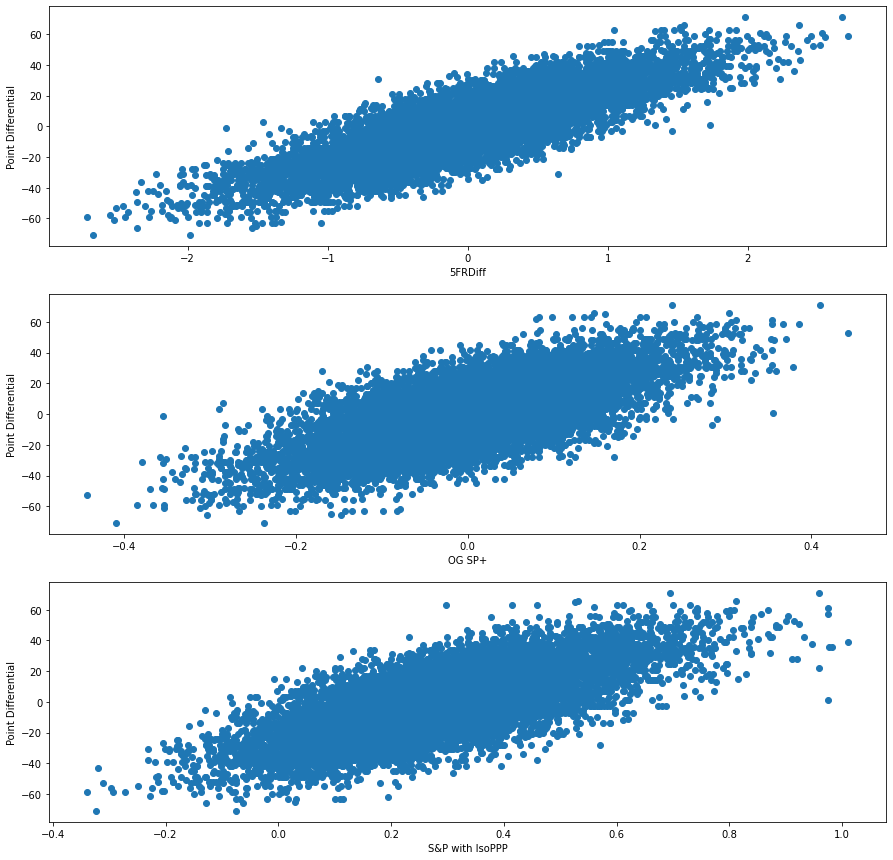

In [40]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [41]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.968029334766474


In [42]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.936352,0.714659
S&PIsoPPPDiff,0.936352,1.000000,0.705644
PtsDiff,0.714659,0.705644,1.000000


In [43]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612,1.325152,2.003140
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612,1.325152,2.003140
2,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533,0.985621,0.190775
3,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533,0.985621,0.190775
4,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265,0.229895,0.524632


In [44]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [45]:
# outliers

In [46]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612,1.325152,2.003140
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612,1.325152,2.003140
2,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533,0.985621,0.190775
3,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533,0.985621,0.190775
5,Ball State,2012,322432050.0,37.0,11.0,0.979920,96,0.437500,0.083333,6.291667,...,0.225997,0.136838,-1.198972,-1.220103,0.225997,0.136838,5.082632,0.165265,0.229895,0.524632


In [47]:
# Linear Regression Model
# from sklearn.linear_model import LinearRegression, SGDClassifier
# from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [48]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data["PtsDiff"][:, np.newaxis])

# print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Mean Pred Score: 0.40555620193481445
Pred Std Dev: 16.2193603515625
Mean Abs Error: 9.475910420454989
Mdn Abs Error: 8.041946411132812
R-squared: 0.6552425977483296
Adj R-squared: 0.6550865283041234



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.646524,0.538748,0.460535,0.774932,0.571732,0.563896,0.981811,0.386511,0.752848,...,0.187106,0.078455,-0.060753,-0.214388,-0.187106,0.078455,-0.060753,0.814258,0.816366,0.809483
OffSRDiff,0.646524,1.000000,0.457254,0.213381,0.564052,0.306573,0.369102,0.641429,0.776121,0.666689,...,0.135157,0.061085,-0.045731,-0.128274,-0.135157,0.061085,-0.045731,0.945130,0.947285,0.943505
OffERDiff,0.538748,0.457254,1.000000,0.116208,0.464188,0.256203,0.301143,0.527860,0.336198,0.795813,...,0.129102,0.013405,-0.078714,-0.128566,-0.129102,0.013405,-0.078714,0.535204,0.536972,0.535241
FPDiff,0.460535,0.213381,0.116208,1.000000,0.577016,0.061918,-0.006254,0.429784,0.010058,0.193882,...,0.103253,0.400494,0.280775,-0.197158,-0.103253,0.400494,0.280775,0.302326,0.303765,0.303036
OppRateDiff,0.774932,0.564052,0.464188,0.577016,1.000000,0.131076,0.130467,0.770086,0.163406,0.633410,...,0.153670,0.079984,-0.047358,-0.187078,-0.153670,0.079984,-0.047358,0.682815,0.685007,0.678687
OppEffDiff,0.571732,0.306573,0.256203,0.061918,0.131076,1.000000,0.799137,0.571399,0.353590,0.389964,...,0.109056,0.024632,-0.025702,-0.113179,-0.109056,0.024632,-0.025702,0.474492,0.474170,0.467624
OppPPDDiff,0.563896,0.369102,0.301143,-0.006254,0.130467,0.799137,1.000000,0.572012,0.412636,0.423454,...,0.120613,-0.003942,-0.051862,-0.091639,-0.120613,-0.003942,-0.051862,0.557789,0.558886,0.552439
PPDDiff,0.981811,0.641429,0.527860,0.429784,0.770086,0.571399,0.572012,1.000000,0.382839,0.742380,...,0.189333,0.072427,-0.071556,-0.215064,-0.189333,0.072427,-0.071556,0.811082,0.813197,0.805922
OppSRDiff,0.386511,0.776121,0.336198,0.010058,0.163406,0.353590,0.412636,0.382839,1.000000,0.477105,...,0.074999,0.038438,-0.017039,-0.061794,-0.074999,0.038438,-0.017039,0.722193,0.724784,0.724455
YPPDiff,0.752848,0.666689,0.795813,0.193882,0.633410,0.389964,0.423454,0.742380,0.477105,1.000000,...,0.159607,0.008764,-0.109945,-0.157674,-0.159607,0.008764,-0.109945,0.765735,0.768243,0.763958


In [49]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.728025,0.646524,0.743137,0.881529,0.318260,0.413473,0.814258,0.816366,0.809483
ActPts,0.728025,1.000000,0.470166,0.535972,0.635398,0.244610,0.304948,0.590715,0.592053,0.588896
Eff,0.646524,0.470166,1.000000,0.657552,0.723046,0.308284,0.228074,0.945130,0.947285,0.943505
Expl,0.743137,0.535972,0.657552,1.000000,0.720784,0.257694,0.243107,0.757489,0.759652,0.755705
FinDrv,0.881529,0.635398,0.723046,0.720784,1.000000,0.301144,0.351627,0.895263,0.897779,0.890086
FldPos,0.318260,0.244610,0.308284,0.257694,0.301144,1.000000,0.071080,0.354267,0.356272,0.355036
Trnovr,0.413473,0.304948,0.228074,0.243107,0.351627,0.071080,1.000000,0.391567,0.344543,0.341030
5FR,0.814258,0.590715,0.945130,0.757489,0.895263,0.354267,0.391567,1.000000,0.997356,0.991597
5FRDiff,0.816366,0.592053,0.947285,0.759652,0.897779,0.356272,0.344543,0.997356,1.000000,0.994206
PredPtsDiff,0.809483,0.588896,0.943505,0.755705,0.890086,0.355036,0.341030,0.991597,0.994206,1.000000


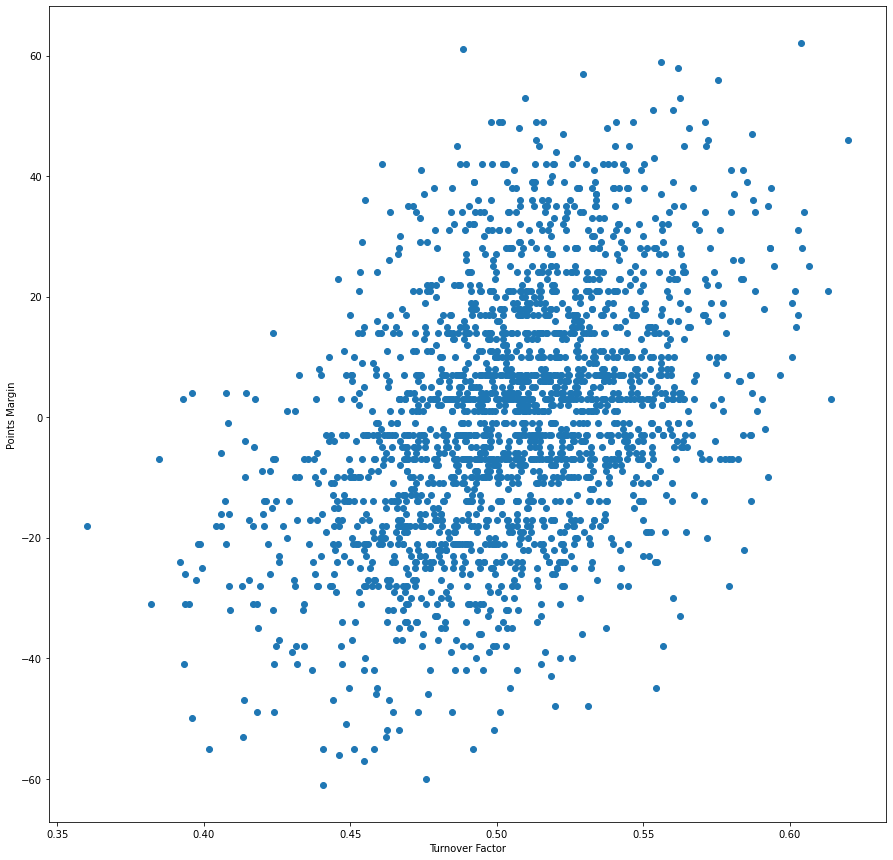

In [50]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

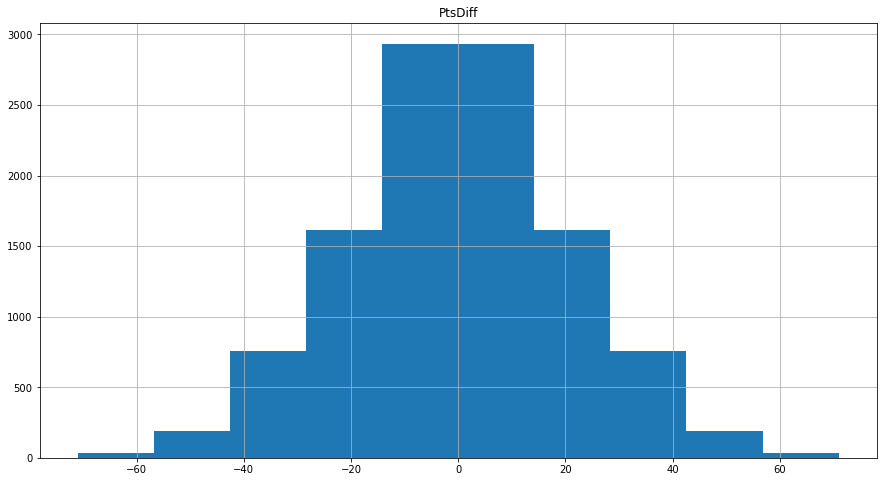

In [51]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

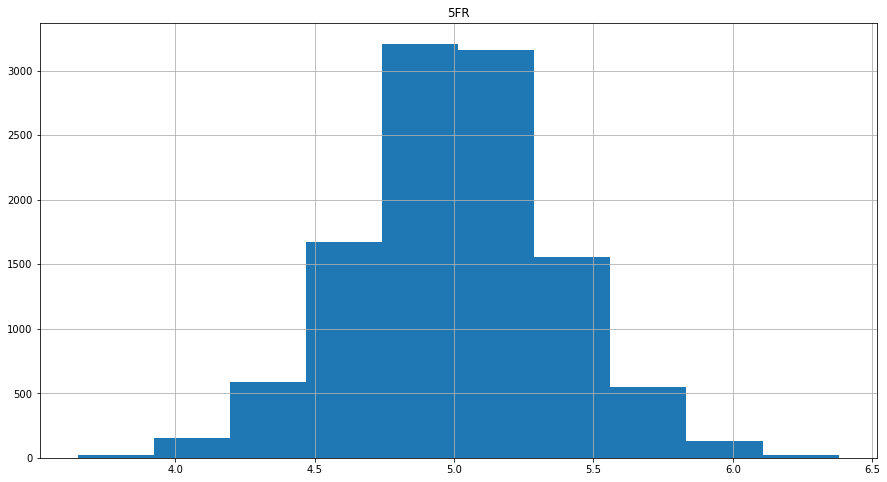

In [52]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

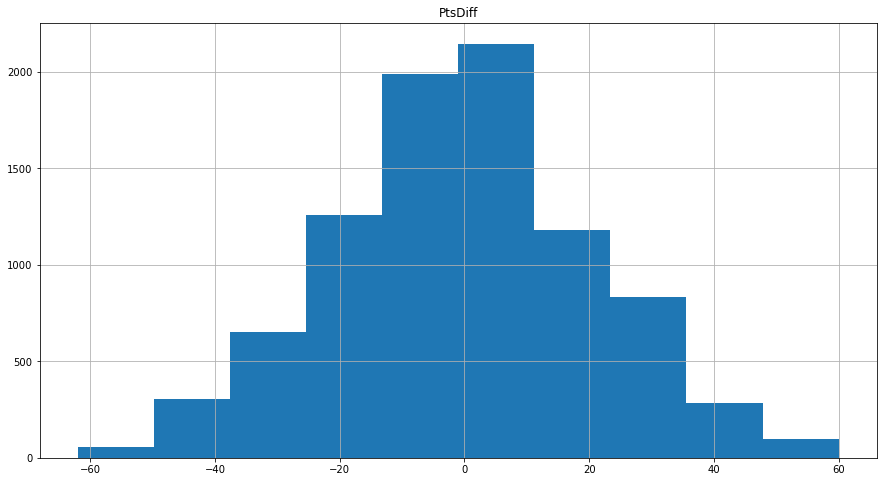

In [53]:
train_data.hist(column='PtsDiff', figsize=(15,8));

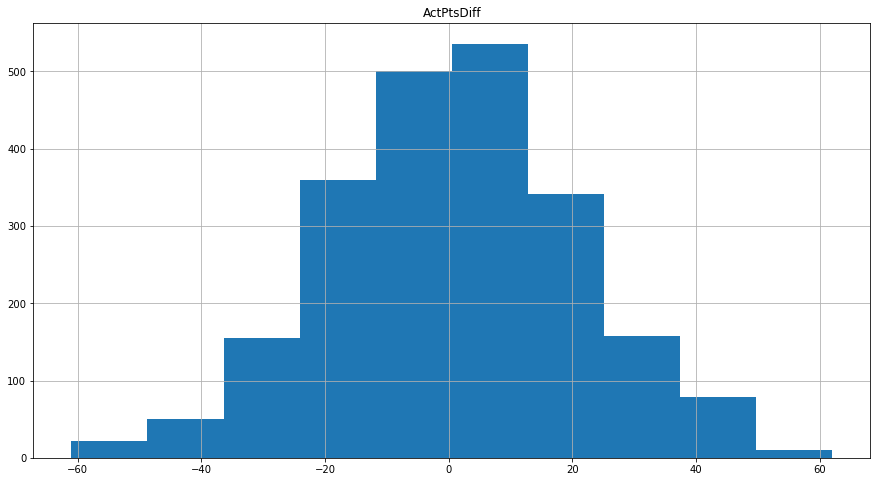

In [54]:
test.hist(column='ActPtsDiff', figsize=(15,8));

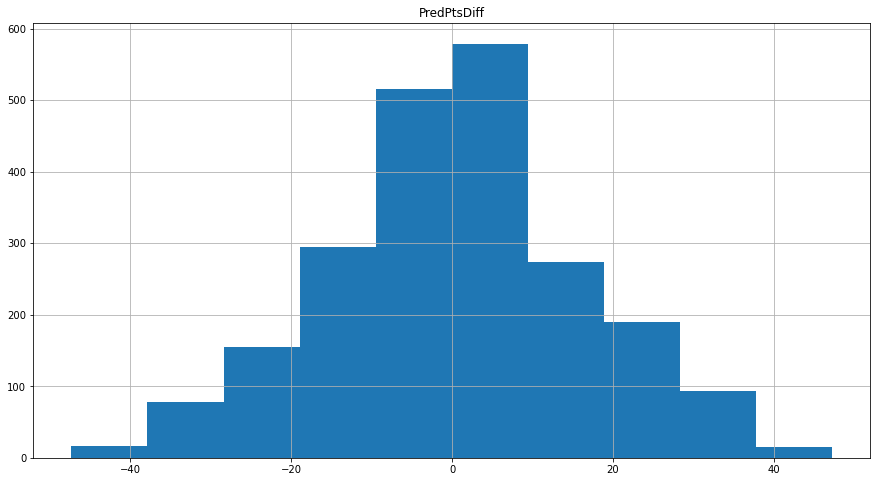

In [55]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [56]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [57]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3 (exact value: -3.396279811859131)
Z score: -0.23440110683441162
Win Prob for Virginia Tech: 40.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.317460,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.095252,0.191733
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.289474,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.903519,-0.191733


In [58]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -3 (exact value: -3.069047212600708)
Z score: -0.2142256796360016
Win Prob for Georgia Tech: 41.52%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.301587,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,4.964540,-0.116518
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.290323,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.081058,0.116518


In [59]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -3 (exact value: -2.8452374935150146)
Z score: -0.20042675733566284
Win Prob for Georgia Tech: 42.06%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.387500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.041941,0.084977
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.368421,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.956965,-0.084977


In [60]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by -1 (exact value: -0.5390927791595459)
Z score: -0.058242060244083405
Win Prob for Mississippi State: 47.68%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.366197,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.997160,0.018954
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.344828,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,4.978207,-0.018954


In [61]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3 (exact value: -2.8452374935150146)
Z score: -0.20042675733566284
Win Prob for Texas A&M: 42.06%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.355556,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.030207,0.06103
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.326923,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.969177,-0.06103


In [62]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(np.array([[tester['5FRDiff'].mean()]]))
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.947227,13,12.0,1.0
2,LSU,0.944078,13,12.0,1.0
3,Clemson,0.913955,13,12.0,1.0
4,Alabama,0.888846,12,11.0,1.0
5,Oklahoma,0.882916,13,11.0,2.0
6,Utah,0.843842,13,11.0,2.0
7,Louisiana,0.823714,13,11.0,2.0
8,Memphis,0.823714,13,11.0,2.0
9,Wisconsin,0.798900,13,10.0,3.0
10,UCF,0.784337,12,9.0,3.0


In [63]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
53,LSU,10.464156,2.535844
77,Ohio State,10.422829,2.577171
78,Oklahoma,9.322537,3.677463
115,Utah,8.242934,4.757066
75,Notre Dame,8.038571,3.961429
11,Baylor,7.544045,5.455955
56,Memphis,7.500006,5.499994
110,UCF,7.483844,4.516156
57,Miami,7.467195,4.532805
128,Wisconsin,7.387106,5.612894


In [64]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2022):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.397336,1.0
1,Florida State,2012,5.393616,2.0
2,Arizona State,2012,5.329176,3.0
3,Notre Dame,2012,5.308616,4.0
4,Georgia,2012,5.306786,5.0
5,Boise State,2012,5.300958,6.0
6,Ohio State,2012,5.288622,7.0
7,Fresno State,2012,5.267703,8.0
8,Bowling Green,2012,5.245412,9.0
9,Oklahoma,2012,5.243370,10.0


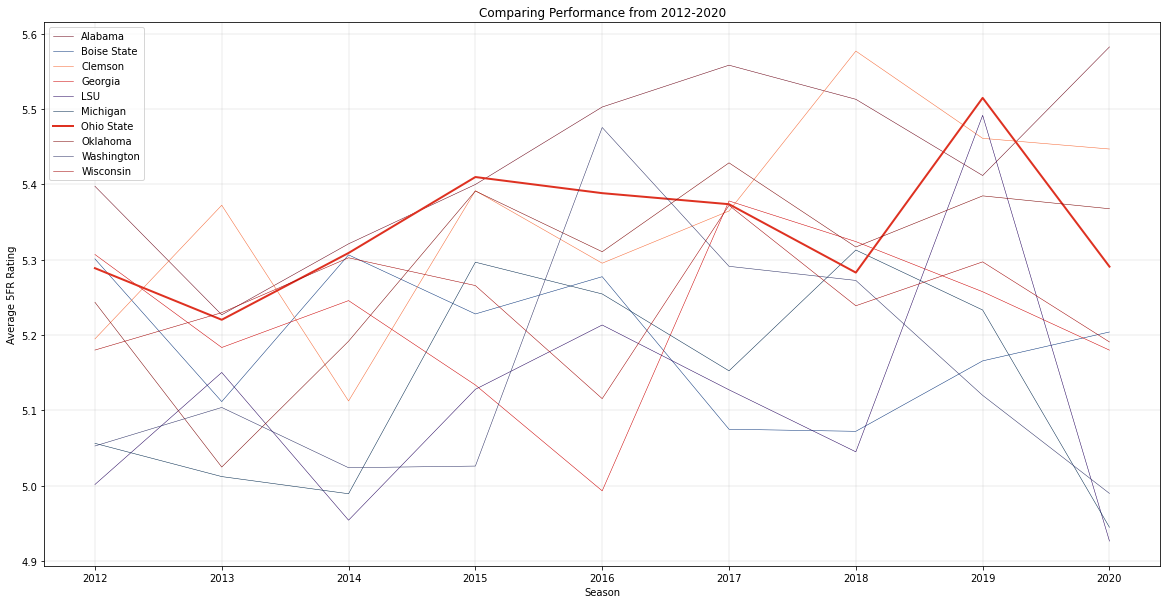

In [65]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [66]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.434649
1,Clemson,5.357211
2,Ohio State,5.341880
3,Oklahoma,5.295378
4,Wisconsin,5.243485
5,Georgia,5.222361
6,Boise State,5.193381
7,Appalachian State,5.180941
8,Notre Dame,5.166141
9,Washington,5.150491


In [67]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
1020,Alabama,2020,5.582278,1.0
762,Clemson,2018,5.576754,1.0
125,Florida State,2013,5.569780,1.0
633,Alabama,2017,5.558014,1.0
891,Ohio State,2019,5.514619,1.0
763,Alabama,2018,5.512751,2.0
506,Alabama,2016,5.502508,1.0
1021,BYU,2020,5.496810,2.0
892,LSU,2019,5.491479,2.0
507,Washington,2016,5.475331,2.0


In [68]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
282,Georgia Tech,2014,5.113504,31.0
54,Georgia Tech,2012,5.028232,55.0
581,Georgia Tech,2016,4.935996,76.0
458,Georgia Tech,2015,4.919085,80.0
857,Georgia Tech,2018,4.892884,96.0
1103,Georgia Tech,2020,4.892534,84.0
984,Georgia Tech,2019,4.890379,94.0
729,Georgia Tech,2017,4.877783,97.0
214,Georgia Tech,2013,4.865628,90.0


In [69]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2021):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323290278.0,Fresno State,2012.0,Air Force,8.0
8,332502005.0,Utah State,2013.0,Air Force,1.0
9,332560068.0,Boise State,2013.0,Air Force,2.0


In [70]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict(np.array([[ffr_diff]]))
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2021, 0, -1, True)

[0.09671054573453064, -20.688127517700195]

In [71]:
# team_triples = [
#     ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
#     ['UCF','Marshall',15,23], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
# #    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
# #    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
# #    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
# #    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
# #    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
# #    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
# #    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
# #    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
# #    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
# #    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
# #    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
# #    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
# #    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
# #    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
# #    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
# #    ----- 23-11 SU / 18-16 ATS ------      
#     ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
# #    ----- 23-12 SU / 18-17 ATS ------    
#     ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
# #    ----- 23-13 SU / 19-17 ATS ------        
#     ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
# #    ----- 24-13 SU / 19-18 ATS ------     
#     ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
# #    ----- 24-14 SU / 19-19 ATS ------     
#     ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
# #    ----- 24-15 SU / 19-20 ATS ------  
#     ["LSU", "Clemson", 6, 17]
# #    ----- 24-16 SU / 19-21 ATS ------  
# ]

# def determine_ml_base_win(row):
#     winner = row.favorite if (row.home_point_diff > 0) else row.opponent
#     return winner

# def determine_ats_base_win(row):
#     mov = row.home_point_diff
#     if (row.spread > 0):
#         if (mov == row.spread):
#             return "Push"
#         winner = row.favorite if (mov > row.spread) else row.opponent
#     elif (row.spread < 0):
#         if (mov == row.spread):
#             return "Push"
#         winner = row.opponent if (mov < row.spread) else row.favorite
#     else:
#         winner = row.favorite if (row.home_point_diff > 0) else row.opponent
#     return winner

# bets = pd.DataFrame()

# for data in team_triples:
#     team1 = data[0]
#     team2 = data[1]
#     spread = data[2] # team 1 is always favorite
#     point_diff = data[3]
#     predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
#     bets = bets.append(pd.DataFrame({
#         "favorite": [team1],
#         "opponent" : [team2],
#         "spread" : [spread],
#         "home_point_diff" : [point_diff],
#         "proj_MOV" : [predictor[1]],
#         "proj_win_prob" : [predictor[0]],
#         "proj_cover_status" : [predictor[1] > spread],
#         "ml_pick": [team1 if (predictor[1] > 0) else team2],
#         "ats_pick": [team1 if (predictor[1] > spread) else team2]
#     }))
# bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
# bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
# bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

In [73]:
# print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
# print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

In [74]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by -3 (exact value: -3.069047212600708)
Z score: -0.2142256796360016
Win Prob for Virginia: 41.52%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.378378,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,5.036311,0.113568
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.290909,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,4.922742,-0.113568


In [75]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 4 (exact value: 3.7953248023986816)
Z score: 0.20899520814418793
Win Prob for North Carolina: 58.28%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.340426,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.105578,0.189469
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.320755,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.916109,-0.189469


In [76]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 14 (exact value: 13.99248218536377)
Z score: 0.8376979827880859
Win Prob for Pittsburgh: 79.89%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.260870,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.286047,0.607556
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.163265,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.678491,-0.607556


In [77]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12 (exact value: -12.041946411132812)
Z score: -0.7674471735954285
Win Prob for Auburn: 22.14%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.373333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.251737,0.521503
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.258065,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.730234,-0.521503


In [78]:
predict_matchup("Georgia Tech", "Georgia", 2019, week = 16, games_to_consider = 4, adjust_hfa = True, adjust_covid = False)
# stored_game_boxes[(stored_game_boxes.GameID.isin(grouped_by_year.get_group(("Georgia", 2019))[:16].GameID.tail(4)))]
# generate_win_prob(401110867, 2019)
# calculate_box_score(401110867, 2019)

[0.48153956697322087, -0.34523749351501465]

In [79]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    if (row.Team == row.HomeTeam and row.ActualMOV > 0):
        return prob
    elif (row.Team == row.AwayTeam and row.ActualMOV < 0):
        return prob
    else:
        return 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"), adjust_covid=(row.Year == 2020))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"), adjust_covid=(row.Year == 2020))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

In [80]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

# calculate_box_score(401112511, 2019)[["OppPPDDiff","OppRateDiff","OppSRDiff"]]

# drives[(drives.game_id == 401112511) & (drives.offense == "Georgia Tech") & (drives.start_yardline + drives.yards >= 60)].drive_pts.mean()

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 20 (exact value: 19.701589584350586)
Z score: 1.189691424369812
Win Prob for Clemson: 88.29%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 10 (exact value: 10.319589614868164)
Z score: 0.6112468838691711
Win Prob for Georgia Tech: 72.95%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -8 (exact value: -7.707364082336426)
Z score: -0.5001997947692871
Win Prob for The Citadel: 30.85%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 8 (exact value: 8.181453704833984)
Z score: 0.4794207215309143
Win Prob for Temple: 68.42%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 4 (exact value: 3.7953248023986816)
Z score: 0.20899520814418793
Win Prob

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401111653.0,2019,Georgia Tech,Clemson,Away,-28.706648,4.050152,-38.0,88.291615
1,401112441.0,2019,Georgia Tech,South Florida,Home,12.819590,77.797844,4.0,72.948193
2,401112452.0,2019,Georgia Tech,The Citadel,Home,49.766731,99.883020,-3.0,69.153280
3,401112469.0,2019,Georgia Tech,Temple,Away,4.593533,62.104154,-22.0,68.418032
4,401112475.0,2019,Georgia Tech,North Carolina,Home,-0.896280,46.801352,-16.0,41.722599
5,401112480.0,2019,Georgia Tech,Duke,Away,-10.681454,26.318482,-18.0,73.650349
6,401112488.0,2019,Georgia Tech,Miami,Away,-12.819590,22.202156,7.0,58.481446
7,401112498.0,2019,Georgia Tech,Pittsburgh,Home,1.210869,51.979989,-10.0,20.110017
8,401112504.0,2019,Georgia Tech,Virginia,Away,-9.662865,28.408229,-5.0,41.518554
9,401112511.0,2019,Georgia Tech,Virginia Tech,Home,0.797858,50.964838,-45.0,0.193104


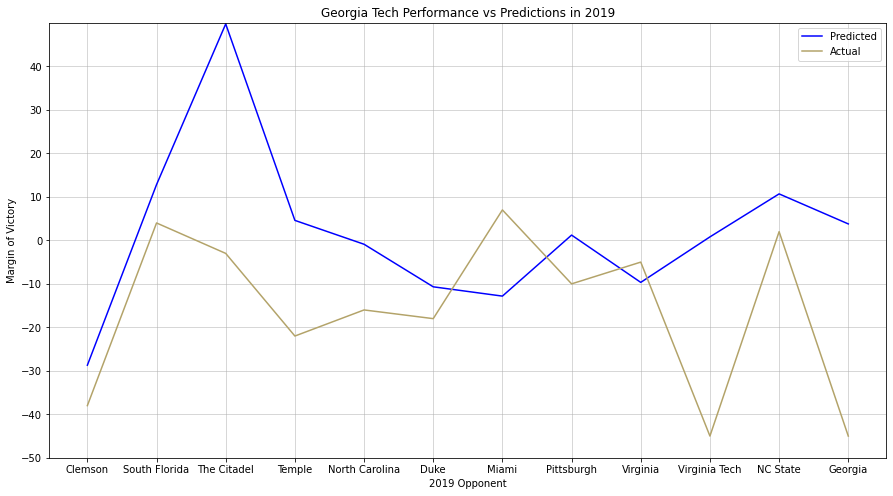

In [81]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 31 (exact value: 31.281673431396484)
Z score: 1.903658151626587
Win Prob for Georgia Tech: 97.15%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -6 (exact value: -5.591434001922607)
Z score: -0.3697427213191986
Win Prob for South Florida: 35.58%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by -3 (exact value: -2.8452374935150146)
Z score: -0.20042675733566284
Win Prob for Pittsburgh: 42.06%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 37 (exact value: 36.5298957824707)
Z score: 2.227235794067383
Win Prob for Clemson: 98.70%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 37 (exact value: 36.5298957824707)
Z score: 2.22

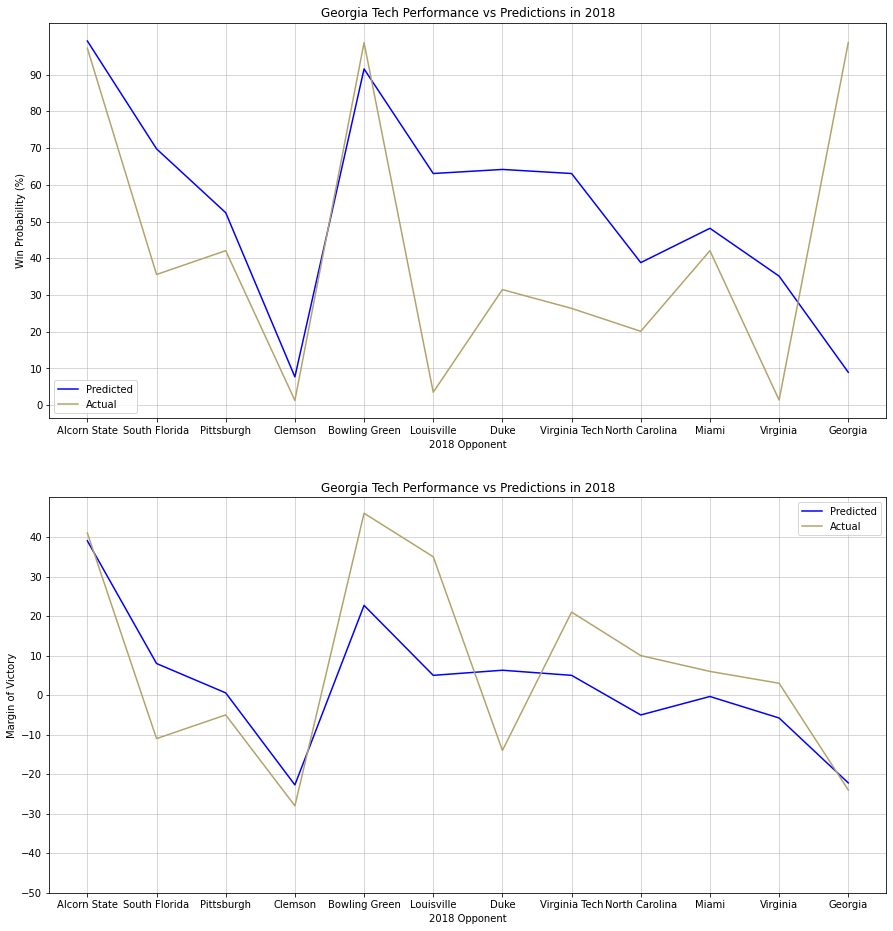

In [82]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

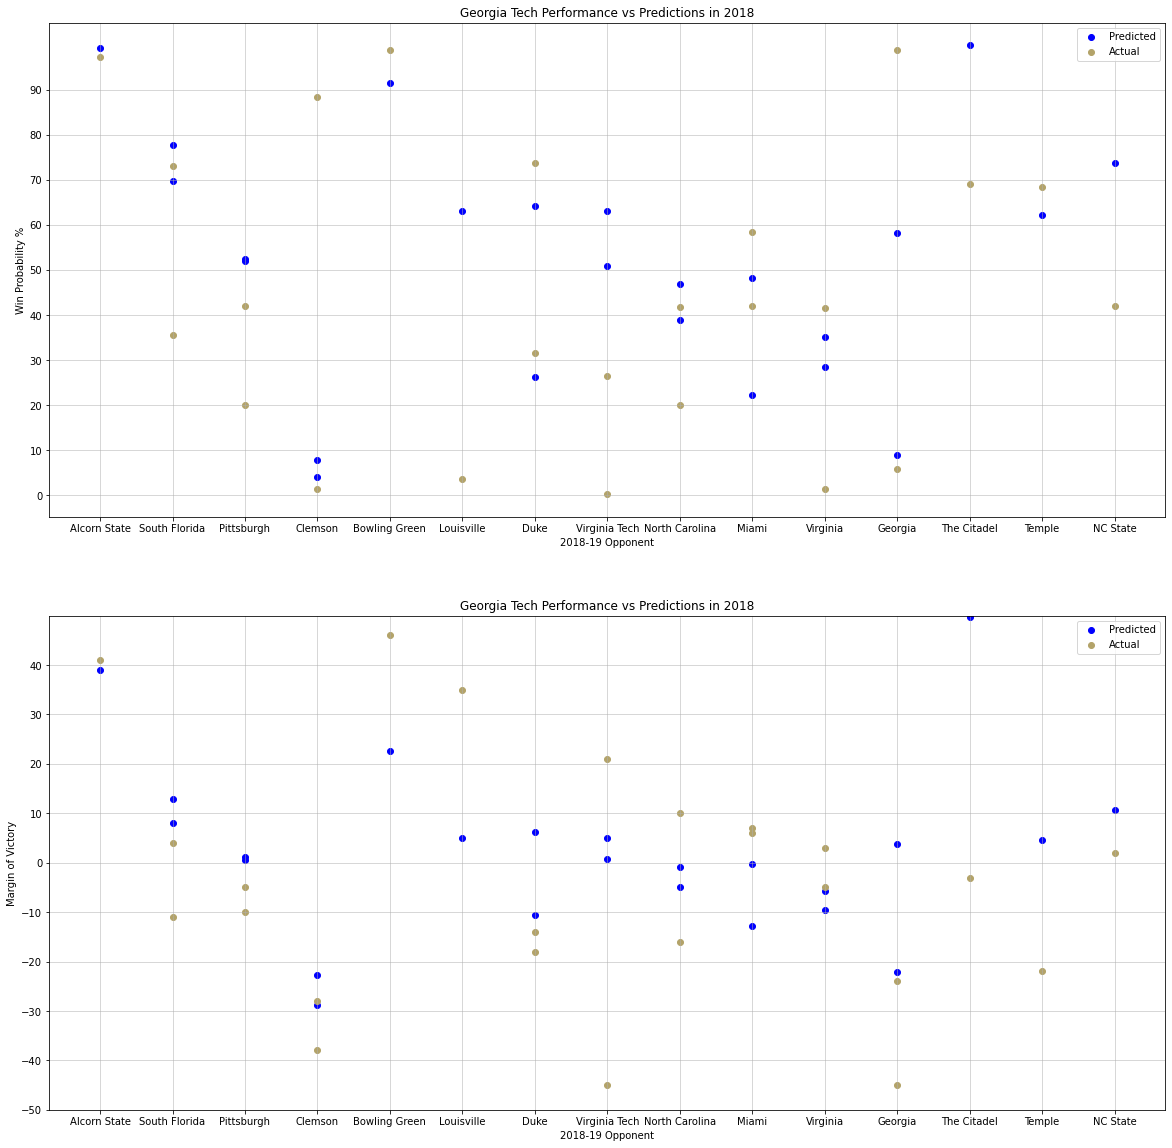

In [83]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [84]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,
2012,1.000000,0.569106,0.455439,0.442681,0.314348,0.252383,0.275152,0.317477,0.373074
2013,0.569106,1.000000,0.463384,0.339954,0.237391,0.274508,0.181575,0.268311,0.123710
2014,0.455439,0.463384,1.000000,0.541582,0.368218,0.242186,0.236723,0.282047,0.222728
2015,0.442681,0.339954,0.541582,1.000000,0.599137,0.459474,0.365219,0.394518,0.299783
2016,0.314348,0.237391,0.368218,0.599137,1.000000,0.510219,0.323631,0.458054,0.316456
2017,0.252383,0.274508,0.242186,0.459474,0.510219,1.000000,0.592307,0.491428,0.321551
2018,0.275152,0.181575,0.236723,0.365219,0.323631,0.592307,1.000000,0.569259,0.379863
2019,0.317477,0.268311,0.282047,0.394518,0.458054,0.491428,0.569259,1.000000,0.560937
2020,0.373074,0.123710,0.222728,0.299783,0.316456,0.321551,0.379863,0.560937,1.000000


In [85]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 4.368832145173557


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,29.422779,-9.181454
1,2020,Georgia Tech,UCF,Home,47.249066,-0.713749
2,2020,Georgia Tech,Syracuse,Away,56.857461,2.396280
3,2020,Georgia Tech,Louisville,Home,51.469086,1.002961
4,2020,Georgia Tech,Clemson,Home,9.475136,-20.875082
5,2020,Georgia Tech,Boston College,Away,56.495975,2.247221
6,2020,Georgia Tech,Notre Dame,Home,15.387804,-16.137247
7,2020,Georgia Tech,Pittsburgh,Home,43.142539,-2.396280
8,2020,Georgia Tech,Miami,Away,24.376035,-11.665970
9,2020,Georgia Tech,Duke,Home,53.143479,1.684891


In [86]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 5.035022095340028


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,8.879681,-22.272520
1,2019,Georgia Tech,South Florida,Home,61.626291,5.201303
2,2019,Georgia Tech,The Citadel,Home,99.245286,39.820374
3,2019,Georgia Tech,Temple,Away,49.863855,-0.460907
4,2019,Georgia Tech,North Carolina,Home,43.936831,-2.069047
5,2019,Georgia Tech,Duke,Away,41.257386,-3.988883
6,2019,Georgia Tech,Miami,Away,29.422779,-9.181454
7,2019,Georgia Tech,Pittsburgh,Home,43.142539,-2.396280
8,2019,Georgia Tech,Virginia,Away,39.333015,-4.795325
9,2019,Georgia Tech,Virginia Tech,Home,43.142539,-2.396280


In [87]:
line_data = pd.DataFrame()

for i in range(2013, 2021):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    if "ï»¿id" in ln.columns:
        ln["id"] = ln["ï»¿id"]
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")
# print(f"2020 Spreads imported: {len(line_data[line_data.year == 2020].id.to_list())}")
# games[(games.id.isin(line_data[line_data.year == 2020].id.to_list()))].head()

Spreads imported: 19908


In [89]:
opponent_game_ids[(opponent_game_ids.Season == 2020) & (opponent_game_ids.Team == "Georgia Tech")].Week.to_list()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [90]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = (int(weeks[0]) - 1) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = (int(weeks[0]) - 1) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [91]:
historic_validation = pd.DataFrame()
for i in range(2013, 2021):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 593 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 586 games with betting lines for 2013 season.
[Simulation] Creating projections for 586 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 609 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 561 games with betting lines for 2014 season.
[Simulation] Creating projections for 561 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 652 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 623 games with betting lines for 2015 season.
[Simulation] Creating projections for 623 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,403,183,0,0.687713
1,ATS,2013,296,283,7,0.505119
0,ML,2014,374,187,0,0.666667
1,ATS,2014,303,245,13,0.540107
0,ML,2015,432,191,0,0.693419
1,ATS,2015,326,280,17,0.523274
0,ML,2016,427,188,0,0.694309
1,ATS,2016,327,271,17,0.531707
0,ML,2017,467,203,0,0.697015
1,ATS,2017,342,310,18,0.510448


In [94]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ML")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2020) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2020) if betting $5 per game: $8548.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
0,ML,2013,403,183,0,0.687713,2930,1008.5,63.031250,0.344198
0,ML,2014,374,187,0,0.666667,2805,841.5,52.593750,0.300000
0,ML,2015,432,191,0,0.693419,3115,1109.5,73.966667,0.356180
0,ML,2016,427,188,0,0.694309,3075,1101.0,73.400000,0.358049
0,ML,2017,467,203,0,0.697015,3350,1218.5,81.233333,0.363731
0,ML,2018,432,185,0,0.700162,3085,1142.5,76.166667,0.370340
0,ML,2019,474,192,0,0.711712,3330,1314.0,87.600000,0.394595
0,ML,2020,310,134,0,0.698198,2220,813.0,50.812500,0.366216


In [93]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.6936493463479492
Avg ATS Win %: 0.5189368266298241


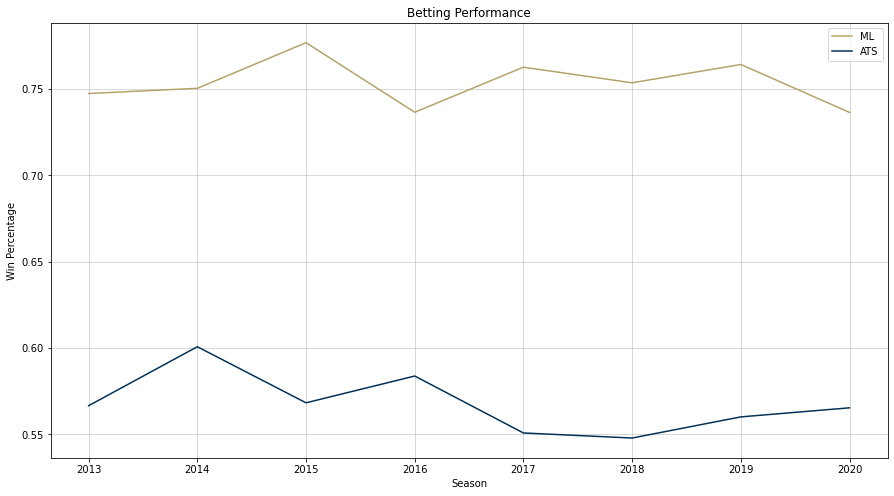

In [105]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [106]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [107]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6314905855754036, 5.169159173965454]

In [108]:
# generate_win_prob(401135295, 2019)

In [109]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [123]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2020)
gen_srs

,Team,5FRSRS,5FRSRSRank
2,Alabama,2.138697,1
5,Arizona State,1.673051,2
21,Clemson,1.576118,3
111,Utah,1.524393,4
110,USC,1.498104,5
76,Oklahoma,1.427613,6
42,Iowa State,1.418840,7
33,Georgia,1.402129,8
28,Florida,1.349494,9
107,UCLA,1.343014,10


In [111]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 8 (exact value: 8.431560516357422)
Z score: 0.5298113822937012
Win Prob for Georgia Tech: 70.19%
---


[0.701878643666639, 3.0]

In [112]:
generate_win_prob(401234568, 2020)

Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.197370529174805)
Z score: 0.5158846378326416
Win Prob for UCF: 69.70%
---


[0.6970325079532862, 28.0]

In [113]:
generate_win_prob(401234594, 2020)

Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Syracuse: 44.59%
---


[0.44591201581656525, 17.0]

In [114]:
generate_win_prob(401234601, 2020)

Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 12 (exact value: 11.59353256225586)
Z score: 0.717846691608429
Win Prob for Georgia Tech: 76.36%
---


[0.7635740898923087, 19.0]

In [115]:
predict_matchup("Houston", "BYU", 2020, 0, -1,True, True)

[0.5376372299878039, 1.1111457645893097]

In [116]:
preds_2020 = [
    ["Miami","Virginia",12],
    ["Texas","Baylor",10.5],
    ["BYU","Texas State",28],
    ["Michigan","Minnesota",3],
    ["Auburn","Ole Miss",3],
    ["Ohio State","Nebraska",26]
]

bets_2020 = pd.DataFrame()
for data in preds_2020:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    # preseason picks because not everyone has played games yet; otherwise week == 7; games to consider == 4
    predictor = predict_matchup(team1, team2, 2020, week = 0, games_to_consider = -1, adjust_hfa = True, adjust_covid = True)
    bets_2020 = bets_2020.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets_2020

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Virginia,12.0,12.355023,0.777307,True,Miami,Miami
0,Texas,Baylor,10.5,7.811464,0.688971,False,Texas,Baylor
0,BYU,Texas State,28.0,11.718315,0.765856,False,BYU,Texas State
0,Michigan,Minnesota,3.0,10.488651,0.742845,True,Michigan,Michigan
0,Auburn,Ole Miss,3.0,10.488651,0.742845,True,Auburn,Auburn
0,Ohio State,Nebraska,26.0,20.632269,0.895326,False,Ohio State,Nebraska


In [117]:
line_data[line_data.year == 2020].head()


,id,homeTeam,homeScore,awayTeam,awayScore,lineProvider,overUnder,spread,formattedSpread,year
0,401234576,Navy,3.0,BYU,55.0,Bovada,48.0,1.0,BYU -1.0,2020
1,401234576,Navy,3.0,BYU,55.0,Caesars,48.0,1.5,BYU -1.5,2020
2,401234576,Navy,3.0,BYU,55.0,consensus,48.5,1.0,BYU -1,2020
3,401234576,Navy,3.0,BYU,55.0,numberfire,48.5,1.5,BYU -1.5,2020
4,401234576,Navy,3.0,BYU,55.0,teamrankings,48.5,1.0,BYU -1,2020


In [118]:
sched_2020 = generate_schedule_analysis(team = "Georgia Tech", year = 2020)
sched_2020

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 8 (exact value: 8.431560516357422)
Z score: 0.5298113822937012
Win Prob for Georgia Tech: 70.19%
---
Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.197370529174805)
Z score: 0.5158846378326416
Win Prob for UCF: 69.70%
---
Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Syracuse: 44.59%
---
Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 12 (exact value: 11.59353256225586)
Z score: 0.717846691608429
Win Prob for Georgia Tech: 76.36%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 66.0
Proj MOV: Clemson by 35 (exact value: 35.27800750732422)
Z score: 2.1263089179992676
Win Prob for Clemson: 98.33%
---
Game: Georgi

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401234563.0,2020,Georgia Tech,Florida State,Away,-10.488651,25.715481,3.0,29.812136
1,401234568.0,2020,Georgia Tech,UCF,Home,3.669159,59.739195,-28.0,30.296749
2,401234594.0,2020,Georgia Tech,Syracuse,Away,1.764560,53.050079,-17.0,44.591202
3,401234601.0,2020,Georgia Tech,Louisville,Home,-1.764560,46.949921,19.0,76.357409
4,401234610.0,2020,Georgia Tech,Clemson,Home,-23.554319,8.498248,-66.0,1.673877
5,401234617.0,2020,Georgia Tech,Boston College,Away,2.080618,53.797126,-21.0,59.457017
6,401234626.0,2020,Georgia Tech,Notre Dame,Home,-3.491945,42.886974,-18.0,16.754308
7,401234652.0,2020,Georgia Tech,Duke,Home,0.767768,52.951988,23.0,59.478755
8,401234659.0,2020,Georgia Tech,NC State,Away,1.764560,53.050079,-10.0,59.149895
9,401261245.0,2020,Georgia Tech,Pittsburgh,Home,4.413564,61.442473,-14.0,29.812136


In [119]:
print(f"Expected 2nd order wins: {sched_2020.PostGameWinProb.sum() / 100}")

Expected 2nd order wins: 4.073834830442262


In [120]:
model.save_model('pgwp_model.model')

In [121]:
opp_2021_df = pd.DataFrame(data={
    "Team" : ["Northern Illinois","Kennesaw State","Clemson","North Carolina","Pittsburgh","Duke","Virginia","Virginia Tech","Miami","Boston College","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Away","Neutral","Home","Away","Away","Home","Away","Home","Away","Home"]
})
georgia_tech_2021 = generate_schedule_predictions("Georgia Tech", opp_2021_df, 2021)
print(f"Expected 2nd order wins: {georgia_tech_2021.PredWinProb.sum() / 100}")
georgia_tech_2021

Expected 2nd order wins: 5.223723585105924


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2021,Georgia Tech,Northern Illinois,Home,72.216298,9.431561
1,2021,Georgia Tech,Kennesaw State,Home,99.525148,43.136299
2,2021,Georgia Tech,Clemson,Away,8.904633,-22.167406
3,2021,Georgia Tech,North Carolina,Neutral,30.144578,-9.226052
4,2021,Georgia Tech,Pittsburgh,Home,46.949921,-1.764560
5,2021,Georgia Tech,Duke,Away,55.073537,2.622012
6,2021,Georgia Tech,Virginia,Away,42.628476,-2.647407
7,2021,Georgia Tech,Virginia Tech,Home,44.926463,-2.622012
8,2021,Georgia Tech,Miami,Away,28.252650,-9.197371
9,2021,Georgia Tech,Boston College,Home,60.240617,3.887394


In [122]:
generate_win_prob(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12 (exact value: -11.721148490905762)
Z score: -0.6686245203018188
Win Prob for Auburn: 25.19%
---


[0.25186751349810854, 3.0]

In [127]:
georgia_tech_2021.PredWinProb = georgia_tech_2021.PredWinProb.round(2)
georgia_tech_2021.PredMOV = georgia_tech_2021.PredMOV.round(2)
georgia_tech_2021.to_csv("results/2021_schedule.csv",index=False)